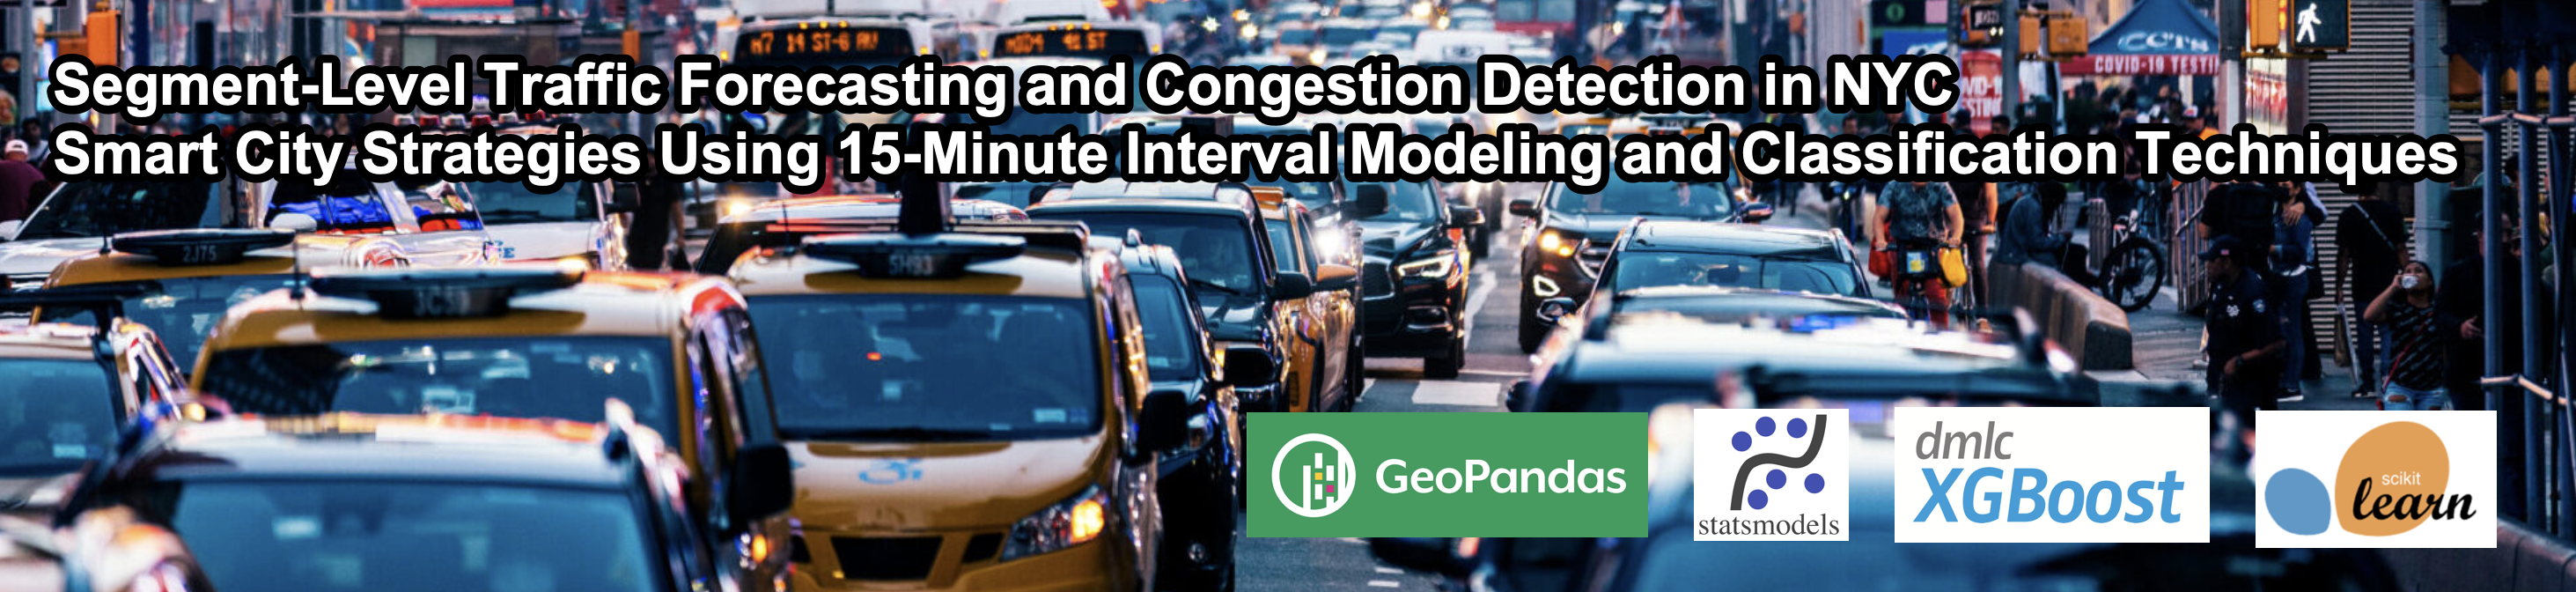

## 1. Introduction

### 1.1 Problem Statement

New York City faces severe and worsening traffic congestion. In 2023, the city recorded over 335 million vehicle crossings on an all-time high. As a result, NYC drivers lost an average of 101–102 hours annually to traffic delays, ranking the city among the most congested urban areas globally. The congestion is not limited to peak hours; midday, weekend, and off-peak traffic have all increased due to shifting travel patterns and lower public transit ridership.

These trends not only contribute to longer commute times and fuel waste, but also undermine economic productivity and quality of life. With over 13,000 signalized intersections, NYC’s road network presents a critical opportunity for data-driven signal optimization to reduce gridlock.


By leveraging 15-minute historical traffic volumes, this project aims to empower NYC DOT with segment-level traffic forecasts and congestion alerts, forming the basis for smart signal timing and targeted mitigation strategies.

### 1.2 Project

This notebook presents a complete end-to-end workflow for predicting 15-minute traffic volumes on NYC street segments: empowering proactive congestion management. Using historical Automated Traffic Recorder (ATR) counts from 2023–2024 (segment, date parts, 15-min volume, borough, geometry, street names, direction), we will:

Forecast Traffic Volumes: Predict the vehicle count for each segment and 15-minute interval.

Flag Congestion Events: Train a binary classifier to label high-volume periods (“congested” vs. “normal”).

Inform Smart Traffic Control: Provide NYC DOT with segment-level forecasts and congestion alerts so signals, routing, and other interventions can be adjusted in realtime reducing travel time, fuel use, and emissions.

We ingest Automated_Traffic_Volume_Counts.csv, convert WKT geometries to (lat, lon), validate and clean the data, engineer time-of-day/holiday features and segment-level lags, and then build—and interpret regression and classification models. Finally, we demonstrate how to serialize models (via joblib), generate future 24-hour forecasts (where no actual volumes exist), and produce rich spatial and temporal visualizations to help NYC DOT become a Smart City leader in traffic management.

Project Contributors:
- **Waldemar Pfeifer**: waldemar.pfeifer@bts.tech

## 2. Data Management & Quality

### 2.1 Load Data & Settings

In [11]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [13]:
raw_df = pd.read_csv("Automated_Traffic_Volume_Counts.csv")
print(f"Memory loaded: {raw_df.memory_usage(deep=True).sum()/1e6:.1f} MB")

Memory loaded: 49.5 MB


In [15]:
raw_df

RequestID       Boro    Yr   M   D  HH  MM  Vol  SegmentID  \
0           36828  Manhattan  2023  11   1  18  30  353     146631   
1           36828  Manhattan  2023  11   1  18  45  330     146631   
2           36828  Manhattan  2023  11   1  19   0  345     146631   
3           36828  Manhattan  2023  11   1  19  15  338     146631   
4           36828  Manhattan  2023  11   1  19  30  321     146631   
...           ...        ...   ...  ..  ..  ..  ..  ...        ...   
109243      37261   Brooklyn  2024   2  12  22  45   85      27660   
109244      37261   Brooklyn  2024   2  12  23   0   81      27660   
109245      37261   Brooklyn  2024   2  12  23  15   62      27660   
109246      37261   Brooklyn  2024   2  12  23  30   59      27660   
109247      37261   Brooklyn  2024   2  12  23  45   73      27660   

                                              WktGeom                 street  \
0       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
1       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
2       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
3       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
4       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
...                                               ...                    ...   
109243   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109244   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109245   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109246   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109247   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   

                        fromSt                    toSt Direction  
0       Harlem River Shoreline  Harlem River Shoreline        EB  
1       Harlem River Shoreline  Harlem River Shoreline        EB  
2       Harlem River Shoreline  Harlem River Shoreline        EB  
3       Harlem River Shoreline  Harlem River Shoreline        EB  
4       Harlem River Shoreline  Harlem River Shoreline        EB  
...                        ...                     ...       ...  
109243          East 32 Street           Aurelia Court        SB  
109244          East 32 Street           Aurelia Court        SB  
109245          East 32 Street           Aurelia Court        SB  
109246          East 32 Street           Aurelia Court        SB  
109247          East 32 Street           Aurelia Court        SB  

[109248 rows x 14 columns]

In [17]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109248 entries, 0 to 109247
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   RequestID  109248 non-null  int64 
 1   Boro       109248 non-null  object
 2   Yr         109248 non-null  int64 
 3   M          109248 non-null  int64 
 4   D          109248 non-null  int64 
 5   HH         109248 non-null  int64 
 6   MM         109248 non-null  int64 
 7   Vol        109248 non-null  int64 
 8   SegmentID  109248 non-null  int64 
 9   WktGeom    109248 non-null  object
 10  street     109248 non-null  object
 11  fromSt     109248 non-null  object
 12  toSt       109248 non-null  object
 13  Direction  109248 non-null  object
dtypes: int64(8), object(6)
memory usage: 11.7+ MB


In [19]:
print(f"Shape: {raw_df.shape}")
print(raw_df[["Vol"]].describe())

Shape: (109248, 14)
                 Vol
count  109248.000000
mean      124.708150
std       206.893578
min         0.000000
25%        25.000000
50%        62.000000
75%       127.000000
max      1829.000000


### 2.2 Create Timestamp

In [22]:
raw_df["timestamp"] = pd.to_datetime(
    raw_df[["Yr", "M", "D", "HH", "MM"]]
      .rename(columns={"Yr": "year", "M": "month", "D": "day",
                       "HH": "hour", "MM": "minute"})
)

In [24]:
raw_df

RequestID       Boro    Yr   M   D  HH  MM  Vol  SegmentID  \
0           36828  Manhattan  2023  11   1  18  30  353     146631   
1           36828  Manhattan  2023  11   1  18  45  330     146631   
2           36828  Manhattan  2023  11   1  19   0  345     146631   
3           36828  Manhattan  2023  11   1  19  15  338     146631   
4           36828  Manhattan  2023  11   1  19  30  321     146631   
...           ...        ...   ...  ..  ..  ..  ..  ...        ...   
109243      37261   Brooklyn  2024   2  12  22  45   85      27660   
109244      37261   Brooklyn  2024   2  12  23   0   81      27660   
109245      37261   Brooklyn  2024   2  12  23  15   62      27660   
109246      37261   Brooklyn  2024   2  12  23  30   59      27660   
109247      37261   Brooklyn  2024   2  12  23  45   73      27660   

                                              WktGeom                 street  \
0       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
1       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
2       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
3       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
4       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
...                                               ...                    ...   
109243   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109244   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109245   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109246   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109247   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   

                        fromSt                    toSt Direction  \
0       Harlem River Shoreline  Harlem River Shoreline        EB   
1       Harlem River Shoreline  Harlem River Shoreline        EB   
2       Harlem River Shoreline  Harlem River Shoreline        EB   
3       Harlem River Shoreline  Harlem River Shoreline        EB   
4       Harlem River Shoreline  Harlem River Shoreline        EB   
...                        ...                     ...       ...   
109243          East 32 Street           Aurelia Court        SB   
109244          East 32 Street           Aurelia Court        SB   
109245          East 32 Street           Aurelia Court        SB   
109246          East 32 Street           Aurelia Court        SB   
109247          East 32 Street           Aurelia Court        SB   

                 timestamp  
0      2023-11-01 18:30:00  
1      2023-11-01 18:45:00  
2      2023-11-01 19:00:00  
3      2023-11-01 19:15:00  
4      2023-11-01 19:30:00  
...                    ...  
109243 2024-02-12 22:45:00  
109244 2024-02-12 23:00:00  
109245 2024-02-12 23:15:00  
109246 2024-02-12 23:30:00  
109247 2024-02-12 23:45:00  

[109248 rows x 15 columns]

### 2.3 Check Duplicates

In [27]:
duplicates = raw_df.duplicated()
print(f" {duplicates.sum()} duplicate rows detected")

 0 duplicate rows detected


### 2.4 Check Check Nulls

In [30]:
nulls = raw_df.isna().sum()
print("Null counts:", nulls[nulls > 0])

Null counts: Series([], dtype: int64)


### 2.5 Negative Values

In [33]:
neg_mask = raw_df["Vol"] < 0
print(f"{neg_mask.sum()} rows with negative vehicle counts ")
raw_df.loc[neg_mask, "Vol"] = pd.NA

0 rows with negative vehicle counts 


### 2.6 Add more columns & Rename

In [36]:
# Add columns & Renanme

raw_df["hour"]       = raw_df["timestamp"].dt.hour
raw_df["dow"]        = raw_df["timestamp"].dt.dayofweek      # 0 = Mon
raw_df["month"]      = raw_df["timestamp"].dt.month
raw_df["month_name"] = raw_df["timestamp"].dt.month_name()
raw_df["minute_of_day"] = raw_df["HH"] * 60 + raw_df["MM"]
raw_df["day_of_year"]   = raw_df["timestamp"].dt.dayofyear
raw_df["date"]          = raw_df["timestamp"].dt.date
raw_df["is_weekend"]    = raw_df["dow"] >= 5
raw_df["year"]          = raw_df["Yr"]

# Delete columns
raw_df = raw_df.drop(columns=["Yr", "M", "D", "HH", "MM"])

raw_df

RequestID       Boro    Vol  SegmentID  \
0           36828  Manhattan  353.0     146631   
1           36828  Manhattan  330.0     146631   
2           36828  Manhattan  345.0     146631   
3           36828  Manhattan  338.0     146631   
4           36828  Manhattan  321.0     146631   
...           ...        ...    ...        ...   
109243      37261   Brooklyn   85.0      27660   
109244      37261   Brooklyn   81.0      27660   
109245      37261   Brooklyn   62.0      27660   
109246      37261   Brooklyn   59.0      27660   
109247      37261   Brooklyn   73.0      27660   

                                              WktGeom                 street  \
0       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
1       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
2       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
3       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
4       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
...                                               ...                    ...   
109243   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109244   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109245   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109246   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109247   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   

                        fromSt                    toSt Direction  \
0       Harlem River Shoreline  Harlem River Shoreline        EB   
1       Harlem River Shoreline  Harlem River Shoreline        EB   
2       Harlem River Shoreline  Harlem River Shoreline        EB   
3       Harlem River Shoreline  Harlem River Shoreline        EB   
4       Harlem River Shoreline  Harlem River Shoreline        EB   
...                        ...                     ...       ...   
109243          East 32 Street           Aurelia Court        SB   
109244          East 32 Street           Aurelia Court        SB   
109245          East 32 Street           Aurelia Court        SB   
109246          East 32 Street           Aurelia Court        SB   
109247          East 32 Street           Aurelia Court        SB   

                 timestamp  hour  dow  month month_name  minute_of_day  \
0      2023-11-01 18:30:00    18    2     11   November           1110   
1      2023-11-01 18:45:00    18    2     11   November           1125   
2      2023-11-01 19:00:00    19    2     11   November           1140   
3      2023-11-01 19:15:00    19    2     11   November           1155   
4      2023-11-01 19:30:00    19    2     11   November           1170   
...                    ...   ...  ...    ...        ...            ...   
109243 2024-02-12 22:45:00    22    0      2   February           1365   
109244 2024-02-12 23:00:00    23    0      2   February           1380   
109245 2024-02-12 23:15:00    23    0      2   February           1395   
109246 2024-02-12 23:30:00    23    0      2   February           1410   
109247 2024-02-12 23:45:00    23    0      2   February           1425   

        day_of_year        date  is_weekend  year  
0               305  2023-11-01       False  2023  
1               305  2023-11-01       False  2023  
2               305  2023-11-01       False  2023  
3               305  2023-11-01       False  2023  
4               305  2023-11-01       False  2023  
...             ...         ...         ...   ...  
109243           43  2024-02-12       False  2024  
109244           43  2024-02-12       False  2024  
109245           43  2024-02-12       False  2024  
109246           43  2024-02-12       False  2024  
109247           43  2024-02-12       False  2024  

[109248 rows x 19 columns]

### 2.7 Convert to String

In [39]:
raw_df["SegmentID"] = raw_df["SegmentID"].astype("string")

## 3. Exploratory Data Analysis (EDA)

### 3.1 Settings & Libraries

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

### 3.2 Numerical Overview

In [45]:
display(raw_df.describe(include="all").T)

count unique                                           top  \
RequestID      109248.0    NaN                                           NaN   
Boro             109248      5                                      Brooklyn   
Vol            109248.0    NaN                                           NaN   
SegmentID        109248    161                                       9000515   
WktGeom          109248    163  POINT (1041074.973834683 193690.47360957888)   
street           109248    122                               FLATBUSH AVENUE   
fromSt           109248    115                                      Dead End   
toSt             109248    108                                      Dead end   
Direction        109248      4                                            NB   
timestamp        109248    NaN                                           NaN   
hour           109248.0    NaN                                           NaN   
dow            109248.0    NaN                                           NaN   
month          109248.0    NaN                                           NaN   
month_name       109248     12                                         March   
minute_of_day  109248.0    NaN                                           NaN   
day_of_year    109248.0    NaN                                           NaN   
date             109248    330                                    2023-11-01   
is_weekend       109248      2                                         False   
year           109248.0    NaN                                           NaN   

                freq                           mean                  min  \
RequestID        NaN                   36623.960292              35707.0   
Boro           42332                            NaN                  NaN   
Vol              NaN                      124.70815                  0.0   
SegmentID       2688                            NaN                  NaN   
WktGeom         2688                            NaN                  NaN   
street          7566                            NaN                  NaN   
fromSt         21712                            NaN                  NaN   
toSt           20166                            NaN                  NaN   
Direction      28704                            NaN                  NaN   
timestamp        NaN  2023-09-25 21:13:03.743409408  2023-01-06 00:00:00   
hour             NaN                           11.5                  0.0   
dow              NaN                        3.02812                  0.0   
month            NaN                       5.191564                  1.0   
month_name     22464                            NaN                  NaN   
minute_of_day    NaN                          712.5                  0.0   
day_of_year      NaN                     141.697715                  6.0   
date             384                            NaN                  NaN   
is_weekend     76992                            NaN                  NaN   
year             NaN                      2023.3471               2023.0   

                               25%                  50%                  75%  \
RequestID                  36179.0              36685.0              37077.0   
Boro                           NaN                  NaN                  NaN   
Vol                           25.0                 62.0                127.0   
SegmentID                      NaN                  NaN                  NaN   
WktGeom                        NaN                  NaN                  NaN   
street                         NaN                  NaN                  NaN   
fromSt                         NaN                  NaN                  NaN   
toSt                           NaN                  NaN                  NaN   
Direction                      NaN                  NaN                  NaN   
timestamp      2023-05-16 14:56:15  2023-10-04 23:52:30  2024-02-08 02:48:45   
hour            

### 3.3 Volume distribution

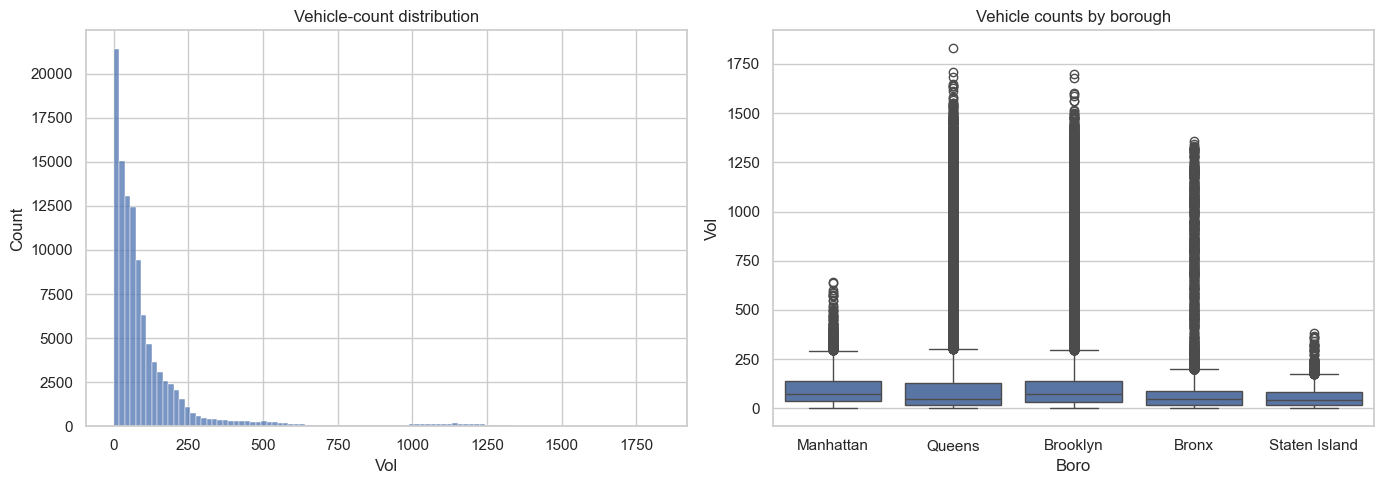

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(
    raw_df["Vol"],
    bins=100,
    ax=ax[0]
)
ax[0].set_title("Vehicle-count distribution")

# Borough split
sns.boxplot(
    data=raw_df,
    x="Boro",
    y="Vol",
    ax=ax[1]
)
ax[1].set_title("Vehicle counts by borough")
plt.tight_layout()

### 3.4 Mean: Hour of Day Visualization

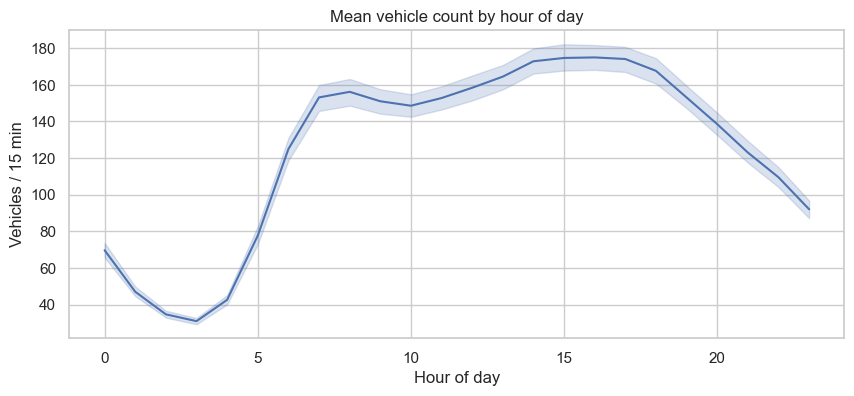

In [49]:
plt.figure(figsize=(10, 4))
sns.lineplot(
    data=raw_df,
    x="hour",
    y="Vol",
    estimator="mean",

)
plt.title("Mean vehicle count by hour of day")
plt.xlabel("Hour of day")
plt.ylabel("Vehicles / 15 min")
plt.show()

### 3.5 Mean: Vehicles Hour of Day by Weekday

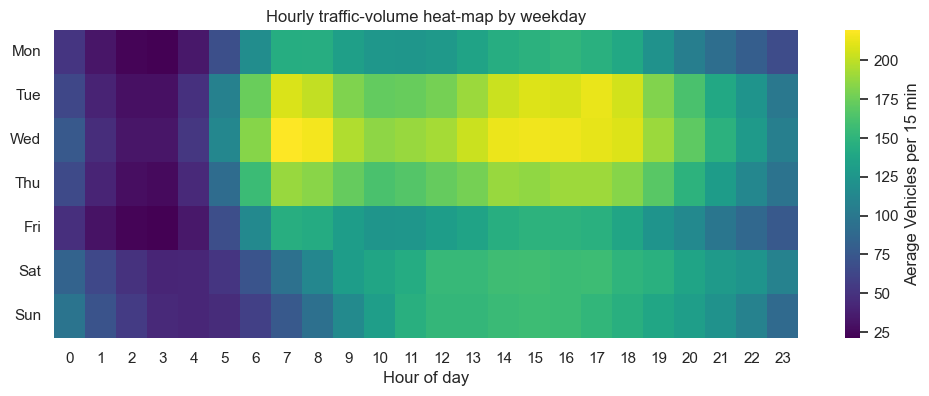

In [51]:
pivot = (
    raw_df
    .groupby(["dow", "hour"])["Vol"]
    .mean()
    .unstack()
    .sort_index()
)
plt.figure(figsize=(12, 4))
sns.heatmap(
    pivot,
    cmap="viridis",
    cbar_kws={"label": "Aerage Vehicles per 15 min"}
)
plt.yticks(
    ticks=np.arange(0.5, 7.5),
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    rotation=0
)
plt.title("Hourly traffic-volume heat-map by weekday")
plt.xlabel("Hour of day")
plt.ylabel("")
plt.show()

### 3.6 Small Correlation matrix (Numeric Columns)

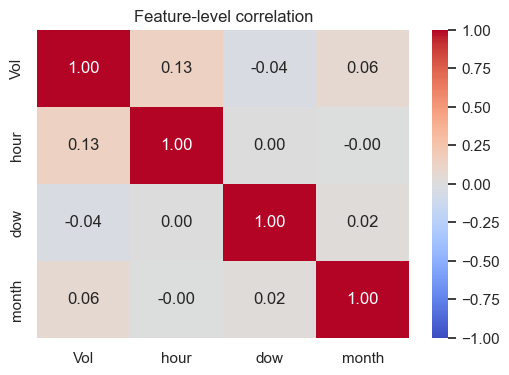

In [53]:
num_feats = ["Vol", "hour", "dow", "month"]
corr = raw_df[num_feats].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Feature-level correlation")
plt.show()

### 3.7 Volume by hour

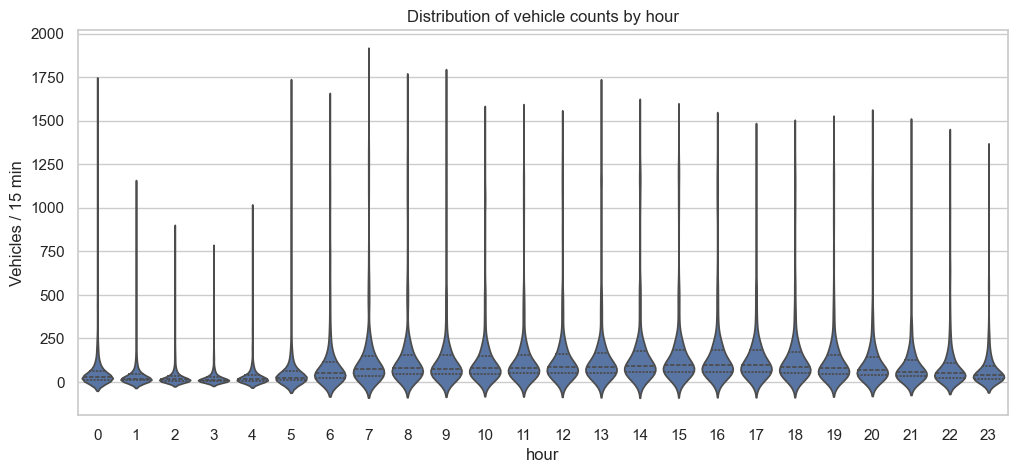

In [55]:
plt.figure(figsize=(12, 5))
sns.violinplot(
    data=raw_df,
    x="hour",
    y="Vol",
    inner="quartile",
    density_norm='width'
)
plt.title("Distribution of vehicle counts by hour")
plt.ylabel("Vehicles / 15 min")
plt.show()

### 3.8 Volume by Direction

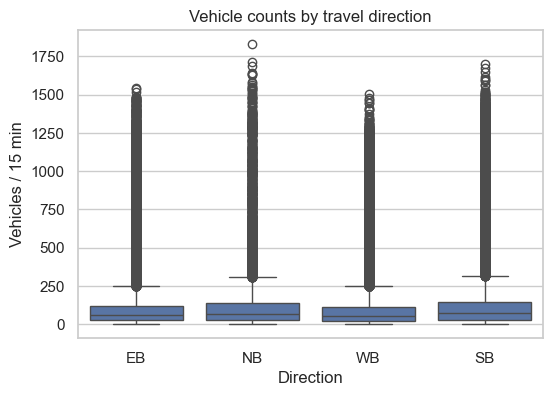

In [57]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=raw_df, x="Direction", y="Vol")
plt.title("Vehicle counts by travel direction")
plt.ylabel("Vehicles / 15 min")
plt.show()

### 3.9 Volume by Boroughs

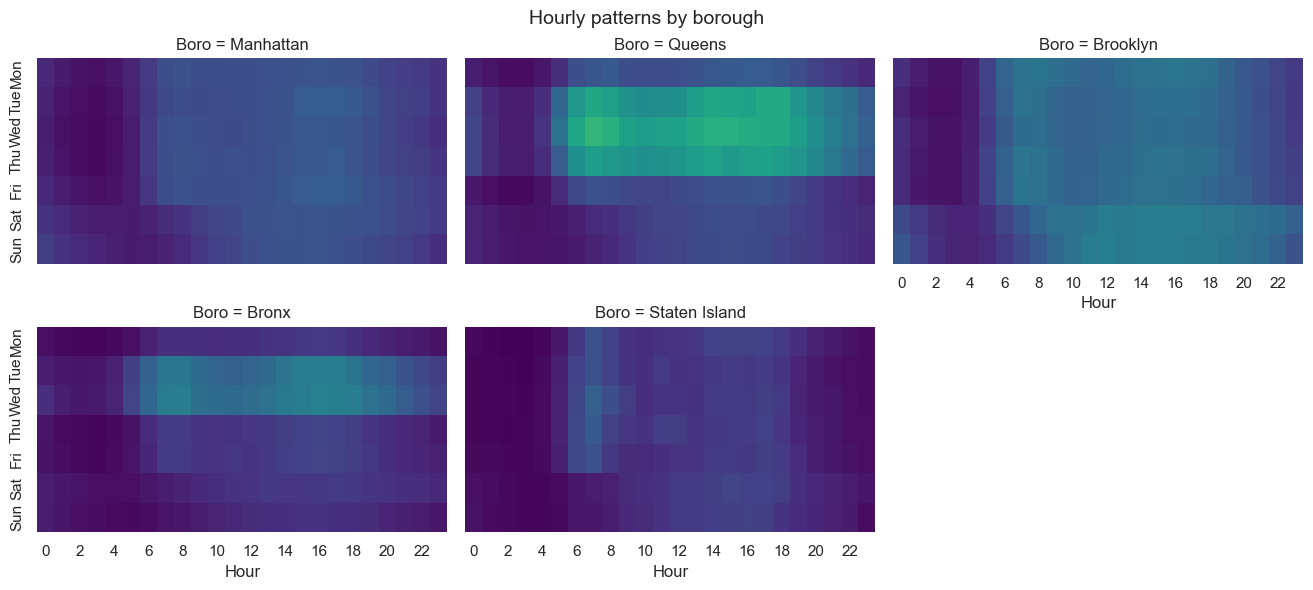

In [59]:
g = sns.FacetGrid(
    raw_df,
    col="Boro", col_wrap=3, height=3, aspect=1.5, sharex=True, sharey=True
)
def hm(data, **kws):
    pivot = (
        data
        .groupby(["dow", "hour"])["Vol"].mean()
        .unstack()
    )
    sns.heatmap(
        pivot,
        cmap="viridis",
        cbar=False,
        vmin=raw_df["Vol"].quantile(0.05),
        vmax=raw_df["Vol"].quantile(0.95),
        **kws
    )
g.map_dataframe(hm)
for ax in g.axes.ravel():
    ax.set_xlabel("Hour"); ax.set_ylabel("")
    ax.set_yticks(
        np.arange(0.5, 7.5),
        labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
    )
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Hourly patterns by borough", fontsize=14)
plt.show()

### 3.10 Segment-level mean vs variance

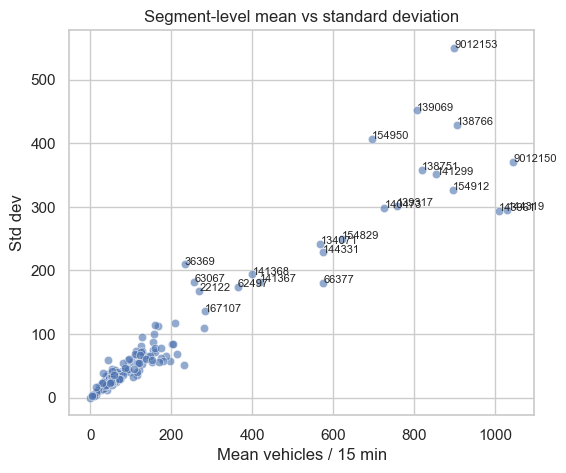

In [61]:
seg_stats = (
    raw_df
    .groupby("SegmentID")["Vol"]
    .agg(["mean", "std"])
    .reset_index()
)
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=seg_stats,
    x="mean",
    y="std",
    alpha=0.6
)

plt.title("Segment-level mean vs standard deviation")
plt.xlabel("Mean vehicles / 15 min")
plt.ylabel("Std dev")
# Annotate top 23 most variable segments
top_var = seg_stats.nlargest(23, "std")
for _, r in top_var.iterrows():
    plt.text(r["mean"], r["std"], int(r["SegmentID"]), fontsize=8)
plt.show()

### 3.11 Busiest Road Segments

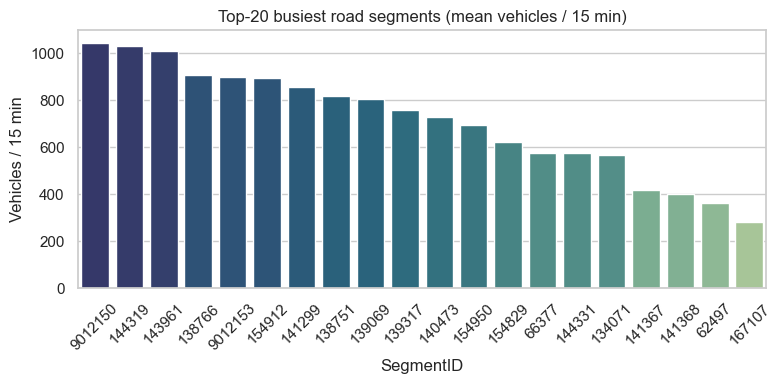

In [63]:
busiest = (
    raw_df.groupby("SegmentID")["Vol"].mean()
    .nlargest(20)
    .reset_index()
)

# Ensure they are plotted in descending order
busiest = busiest.sort_values("Vol", ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(
    data=busiest,
    x="SegmentID",
    y="Vol",
    hue="Vol",
    palette="crest",
    dodge=False,
    order=busiest["SegmentID"],
    legend=False
)
plt.title("Top-20 busiest road segments (mean vehicles / 15 min)")
plt.ylabel("Vehicles / 15 min")
plt.xlabel("SegmentID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 3.12 Autocorrelation of daily totals

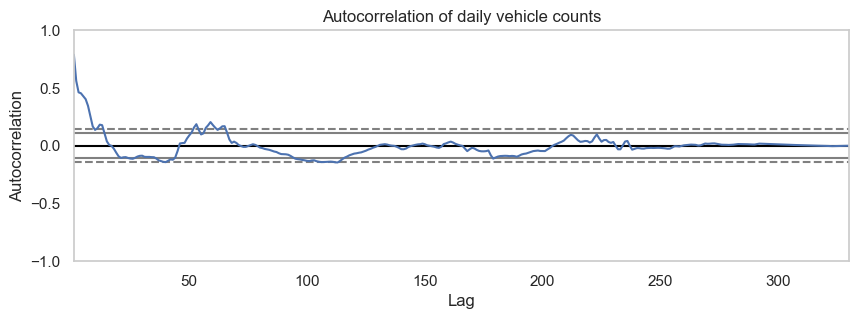

In [65]:
from pandas.plotting import autocorrelation_plot
daily_tot = raw_df.groupby("date")["Vol"].sum()

plt.figure(figsize=(10, 3))
autocorrelation_plot(daily_tot)
plt.title("Autocorrelation of daily vehicle counts")
plt.show()

In [66]:
raw_df

RequestID       Boro    Vol SegmentID  \
0           36828  Manhattan  353.0    146631   
1           36828  Manhattan  330.0    146631   
2           36828  Manhattan  345.0    146631   
3           36828  Manhattan  338.0    146631   
4           36828  Manhattan  321.0    146631   
...           ...        ...    ...       ...   
109243      37261   Brooklyn   85.0     27660   
109244      37261   Brooklyn   81.0     27660   
109245      37261   Brooklyn   62.0     27660   
109246      37261   Brooklyn   59.0     27660   
109247      37261   Brooklyn   73.0     27660   

                                              WktGeom                 street  \
0       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
1       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
2       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
3       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
4       POINT (1002754.5374999298 235875.81836194085)  MADISON AVENUE BRIDGE   
...                                               ...                    ...   
109243   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109244   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109245   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109246   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   
109247   POINT (999446.7779823921 169005.80685982972)        FLATBUSH AVENUE   

                        fromSt                    toSt Direction  \
0       Harlem River Shoreline  Harlem River Shoreline        EB   
1       Harlem River Shoreline  Harlem River Shoreline        EB   
2       Harlem River Shoreline  Harlem River Shoreline        EB   
3       Harlem River Shoreline  Harlem River Shoreline        EB   
4       Harlem River Shoreline  Harlem River Shoreline        EB   
...                        ...                     ...       ...   
109243          East 32 Street           Aurelia Court        SB   
109244          East 32 Street           Aurelia Court        SB   
109245          East 32 Street           Aurelia Court        SB   
109246          East 32 Street           Aurelia Court        SB   
109247          East 32 Street           Aurelia Court        SB   

                 timestamp  hour  dow  month month_name  minute_of_day  \
0      2023-11-01 18:30:00    18    2     11   November           1110   
1      2023-11-01 18:45:00    18    2     11   November           1125   
2      2023-11-01 19:00:00    19    2     11   November           1140   
3      2023-11-01 19:15:00    19    2     11   November           1155   
4      2023-11-01 19:30:00    19    2     11   November           1170   
...                    ...   ...  ...    ...        ...            ...   
109243 2024-02-12 22:45:00    22    0      2   February           1365   
109244 2024-02-12 23:00:00    23    0      2   February           1380   
109245 2024-02-12 23:15:00    23    0      2   February           1395   
109246 2024-02-12 23:30:00    23    0      2   February           1410   
109247 2024-02-12 23:45:00    23    0      2   February           1425   

        day_of_year        date  is_weekend  year  
0               305  2023-11-01       False  2023  
1               305  2023-11-01       False  2023  
2               305  2023-11-01       False  2023  
3               305  2023-11-01       False  2023  
4               305  2023-11-01       False  2023  
...             ...         ...         ...   ...  
109243           43  2024-02-12       False  2024  
109244           43  2024-02-12       False  2024  
109245           43  2024-02-12       False  2024  
109246           43  2024-02-12       False  2024  
109247           43  2024-02-12       False  2024  

[109248 rows x 19 columns]

### 3.13 Radar Plot of Segments

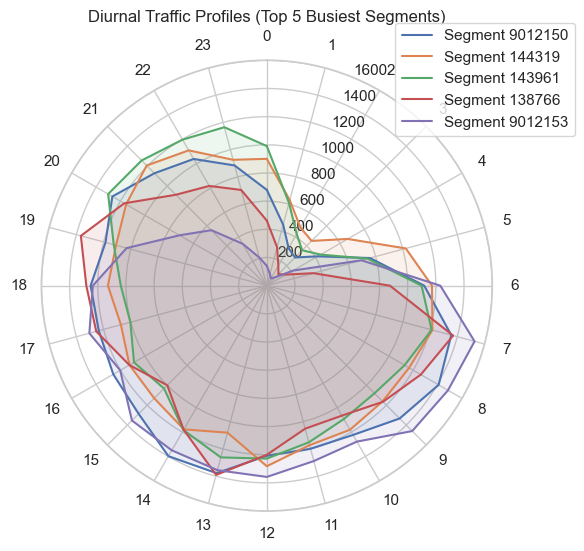

In [68]:
busiest = raw_df.groupby("SegmentID")["Vol"].mean().nlargest(5).index.tolist()

# Build a DataFrame of mean volume per hour for each top segment
radar_df = (
    raw_df[raw_df["SegmentID"].isin(busiest)]
    .groupby([ "SegmentID", raw_df["timestamp"].dt.hour ])["Vol"]
    .mean()
    .reset_index(name="avg_vol")
)

# Pivot so rows=SegmentID, columns=hour 0–23
radar_pivot = radar_df.pivot(index="SegmentID", columns="timestamp", values="avg_vol").fillna(0)

# Prepare radar plotting
angles = np.linspace(0, 2 * np.pi, 24, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)

for seg in busiest:
    hourly = radar_df[radar_df["SegmentID"] == seg].sort_values("timestamp")["avg_vol"].values
    vals = hourly.tolist() + [hourly[0]]  # close the radar plot
    ax.plot(angles, vals, label=f"Segment {seg}")
    ax.fill(angles, vals, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([str(h) for h in range(24)])
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("Diurnal Traffic Profiles (Top 5 Busiest Segments)")
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

### 3.14 Geo Visualizations

#### 3.14.1 Convert WktGeom to Longitude and Latitude

In [71]:
from shapely import wkt
from pyproj import Transformer

transformer = Transformer.from_crs(2263, 4326, always_xy=True)

def wkt_to_lon_lat(point_wkt: str):
    """Safely convert a single WKT point; return (lon, lat) or (nan, nan)."""
    try:
        pt = wkt.loads(point_wkt)
        return transformer.transform(pt.x, pt.y)
    except Exception:
        return (np.nan, np.nan)

lon_lat = raw_df["WktGeom"].apply(wkt_to_lon_lat)
raw_df["lon"] = lon_lat.str[0]
raw_df["lat"] = lon_lat.str[1]

#### 3.14.2 Convert Dataframe into Geodataframe

In [75]:
import geopandas as gpd
from shapely.geometry import Point

gdf = raw_df.reset_index().copy()
# At this point, reset_index() makes a column named 'timestamp' because raw_df's index was timestamp
# So no need to rename; just ensure dtype is datetime
gdf["timestamp"] = pd.to_datetime(gdf["timestamp"])

gdf = gpd.GeoDataFrame(
    gdf,
    geometry=gdf.apply(lambda row: Point(row["lon"], row["lat"]), axis=1),
    crs="EPSG:4326"
)

#### 3.14.3 Average vehicles/15 min map

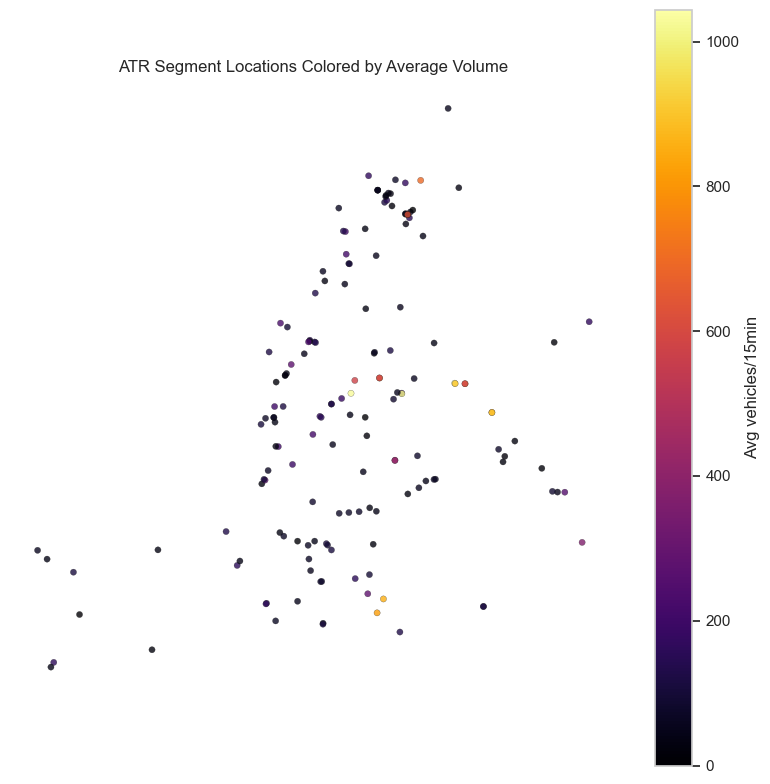

In [78]:
seg_mean = (
    raw_df
    .groupby("SegmentID")["Vol"]
    .mean()
    .rename("avg_vol")
    .reset_index()
)
gdf_seg = (
    gdf.drop_duplicates(subset="SegmentID")
       .merge(seg_mean, on="SegmentID")
)

fig, ax = plt.subplots(figsize=(8, 8))
gdf_seg.plot(
    ax=ax,
    column="avg_vol",
    cmap="inferno",
    markersize=20,
    legend=True,
    legend_kwds={"label": "Avg vehicles/15min"},
    alpha=0.8,
    edgecolor="k",
    linewidth=0.2
)
ax.set_title("ATR Segment Locations Colored by Average Volume")
ax.set_axis_off()
plt.tight_layout()
plt.show()

#### 3.14.4 Average vehicles across specific times Map

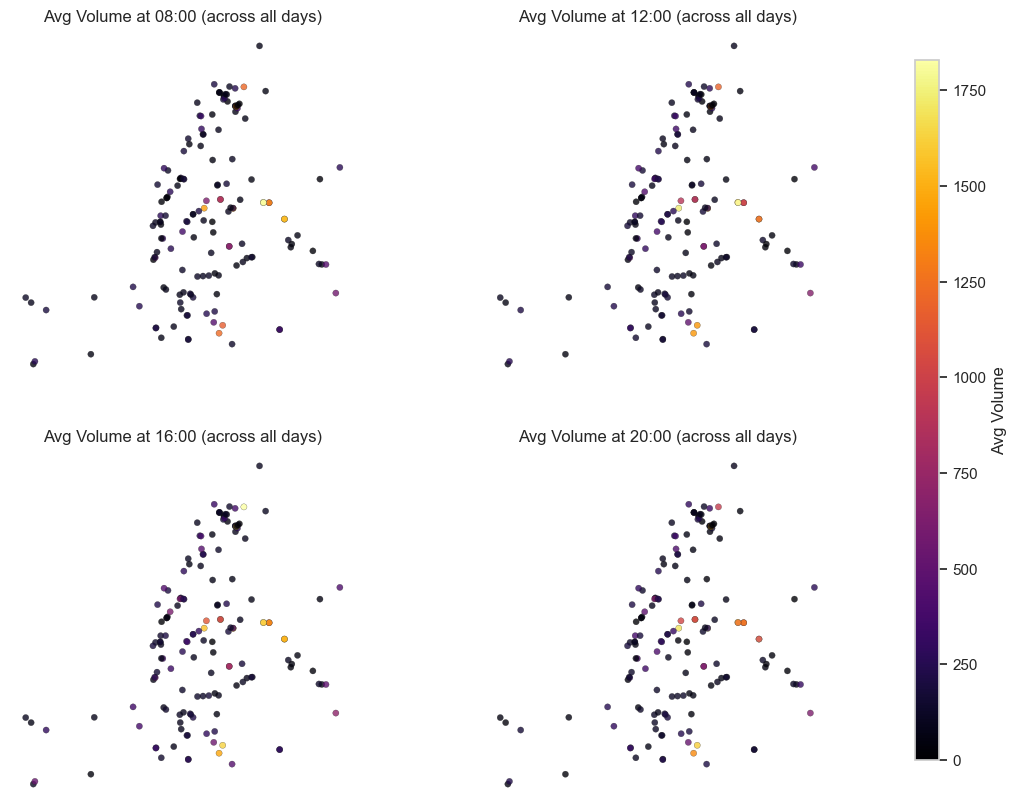

In [81]:
times = ["08:00", "12:00", "16:00", "20:00"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, tstr in zip(axes, times):
    hour, minute = map(int, tstr.split(":"))
    # Filter by timestamp hour & minute
    slice_df = gdf[
        (gdf["timestamp"].dt.hour == hour) &
        (gdf["timestamp"].dt.minute == minute)
    ]
    # Compute mean volume at that time across all days per segment
    mean_slice = (
        slice_df
        .groupby("SegmentID")
        .agg({"Vol": "mean", "geometry": "first"})
        .reset_index()
    )
    mean_gdf = gpd.GeoDataFrame(mean_slice, geometry="geometry", crs="EPSG:4326")
    mean_gdf.plot(
        ax=ax,
        column="Vol",
        cmap="inferno",
        markersize=20,
        legend=False,
        alpha=0.8,
        edgecolor="k",
        linewidth=0.2
    )
    ax.set_title(f"Avg Volume at {tstr} (across all days)")
    ax.set_axis_off()

# Add a single colorbar for all subplots
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(
    cmap="inferno",
    norm=plt.Normalize(vmin=raw_df["Vol"].min(), vmax=raw_df["Vol"].max())
)
sm._A = []
fig.colorbar(sm, cax=cax, label="Avg Volume")

plt.show()

#### 3.14.5 Average vehicles across specific Borouhs

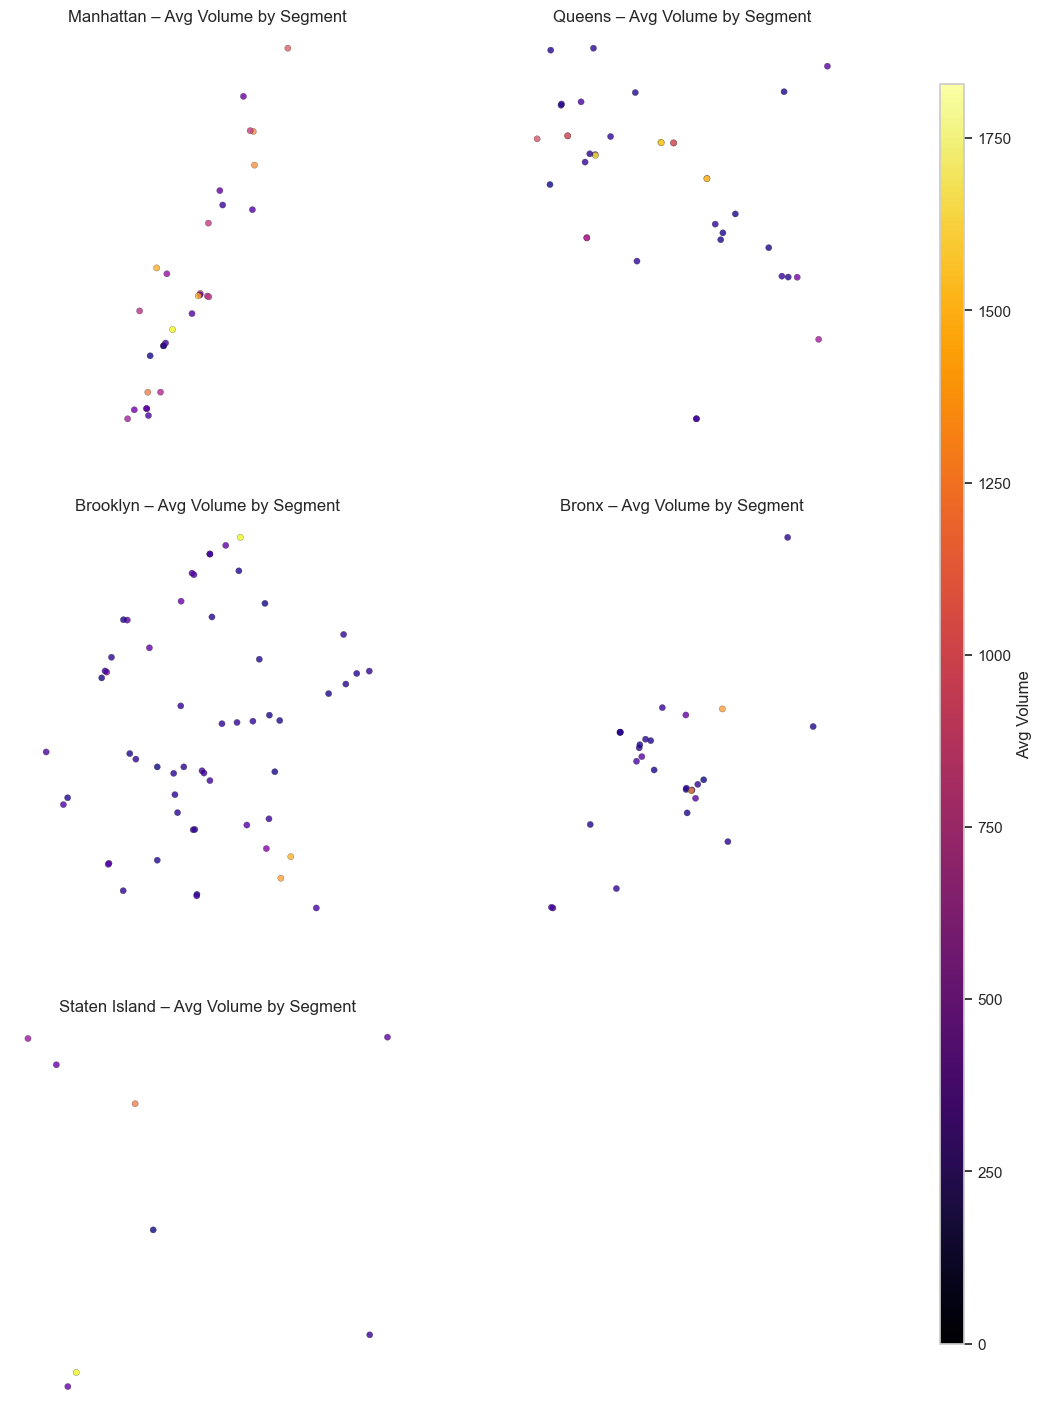

In [85]:
boros = gdf_seg["Boro"].unique()
n = len(boros)
fig, axes = plt.subplots(
    nrows=n//2 + n%2, ncols=2, figsize=(12, 6*(n//2 + n%2))
)
axes = axes.flatten()

for ax, boro in zip(axes, boros):
    subset = gdf_seg[gdf_seg["Boro"] == boro]
    subset.plot(
        ax=ax,
        column="avg_vol",
        cmap="plasma",
        markersize=20,
        legend=False,
        alpha=0.8,
        edgecolor="k",
        linewidth=0.2
    )
    ax.set_title(f"{boro} – Avg Volume by Segment")
    ax.set_axis_off()

for ax in axes[len(boros):]:
    ax.set_visible(False)

# Add a single colorbar for all subplots
fig.subplots_adjust(right=0.85)
cax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(
    cmap="inferno",
    norm=plt.Normalize(vmin=raw_df["Vol"].min(), vmax=raw_df["Vol"].max())
)
sm._A = []
fig.colorbar(sm, cax=cax, label="Avg Volume")

plt.show()

#### 3.14.6 Weekyday vs Weekend Map

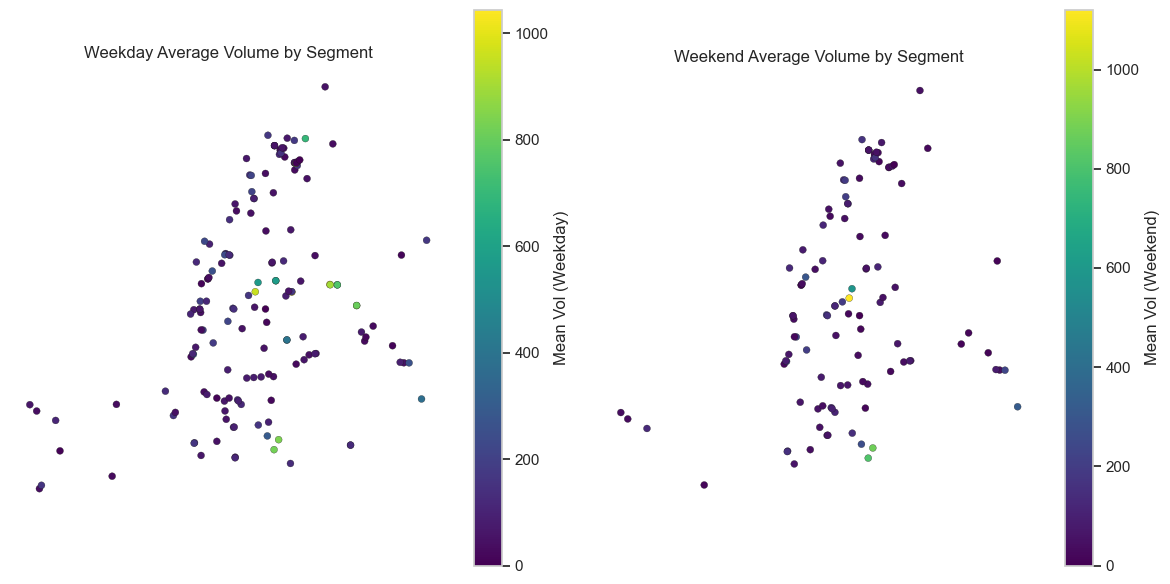

In [89]:
raw_df["is_weekend"] = raw_df["timestamp"].dt.dayofweek >= 5

split_df = (
    raw_df.groupby(["SegmentID", "is_weekend"])
    .agg({"Vol": "mean", "lon": "first", "lat": "first"})
    .reset_index()
)

weekday_df = split_df[split_df["is_weekend"] == False]
weekend_df = split_df[split_df["is_weekend"] == True]

gdf_weekday = gpd.GeoDataFrame(
    weekday_df, 
    geometry=[Point(xy) for xy in zip(weekday_df["lon"], weekday_df["lat"])],
    crs="EPSG:4326"
)
gdf_weekend = gpd.GeoDataFrame(
    weekend_df, 
    geometry=[Point(xy) for xy in zip(weekend_df["lon"], weekend_df["lat"])],
    crs="EPSG:4326"
)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

gdf_weekday.plot(
    ax=axes[0],
    column="Vol",
    cmap="viridis",
    markersize=25,
    legend=True,
    legend_kwds={"label": "Mean Vol (Weekday)"},
    edgecolor="k",
    linewidth=0.2
)
axes[0].set_title("Weekday Average Volume by Segment")
axes[0].set_axis_off()

gdf_weekend.plot(
    ax=axes[1],
    column="Vol",
    cmap="viridis",
    markersize=25,
    legend=True,
    legend_kwds={"label": "Mean Vol (Weekend)"},
    edgecolor="k",
    linewidth=0.2
)
axes[1].set_title("Weekend Average Volume by Segment")
axes[1].set_axis_off()

plt.tight_layout()
plt.show()


## 4. Feature Engineering

### 4.1 Cap extreme values

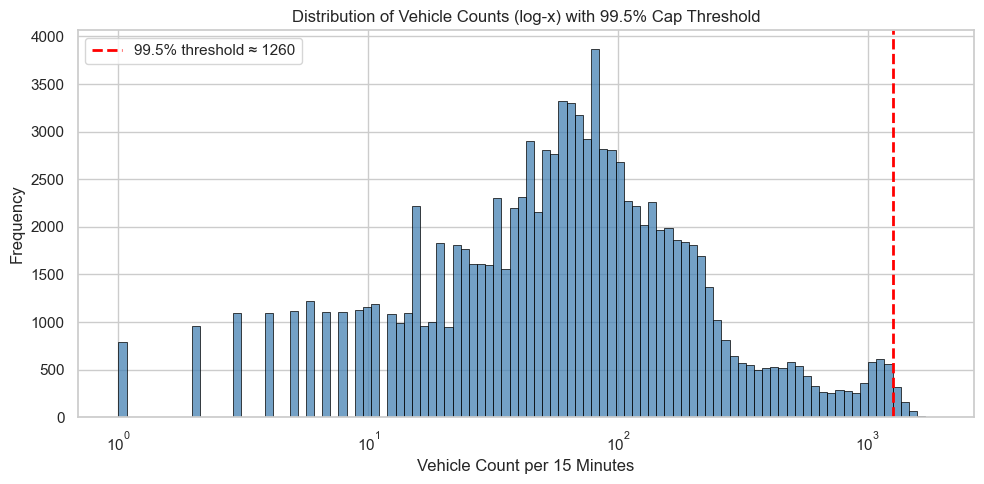

In [95]:
# Compute the upper 0.5% quantile (used later for capping)
upper_cap = raw_df["Vol"].quantile(0.995)

plt.figure(figsize=(10, 5))
sns.histplot(raw_df["Vol"], bins=100, log_scale=(True, False), color="steelblue", edgecolor="black")
plt.axvline(upper_cap, color="red", linestyle="--", linewidth=2, label=f"99.5% threshold ≈ {upper_cap:.0f}")
plt.title("Distribution of Vehicle Counts (log-x) with 99.5% Cap Threshold")
plt.xlabel("Vehicle Count per 15 Minutes")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

In [99]:
extreme_mask = raw_df["Vol"] > upper_cap
print(f"Capping {extreme_mask.sum()} rows")
raw_df.loc[extreme_mask, "Vol"] = upper_cap

Capping 544 rows


### 4.2 Set time index

In [101]:
raw_df = raw_df.set_index("timestamp").sort_index()
display(raw_df.head())

RequestID      Boro   Vol SegmentID  \
timestamp                                                  
2023-01-06 00:00:00      35707  Brooklyn  81.0    151516   
2023-01-06 00:15:00      35707  Brooklyn  67.0    151516   
2023-01-06 00:30:00      35707  Brooklyn  48.0    151516   
2023-01-06 00:45:00      35707  Brooklyn  41.0    151516   
2023-01-06 01:00:00      35707  Brooklyn  42.0    151516   

                                                           WktGeom  \
timestamp                                                            
2023-01-06 00:00:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 00:15:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 00:30:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 00:45:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 01:00:00  POINT (1004852.0243700822 162537.73371917408)   

                              street    fromSt      toSt Direction  hour  dow  \
timestamp                                                                       
2023-01-06 00:00:00  FLATBUSH AVENUE  Dead end  Avenue S        NB     0    4   
2023-01-06 00:15:00  FLATBUSH AVENUE  Dead end  Avenue S        NB     0    4   
2023-01-06 00:30:00  FLATBUSH AVENUE  Dead end  Avenue S        NB     0    4   
2023-01-06 00:45:00  FLATBUSH AVENUE  Dead end  Avenue S        NB     0    4   
2023-01-06 01:00:00  FLATBUSH AVENUE  Dead end  Avenue S        NB     1    4   

                     month month_name  minute_of_day  day_of_year        date  \
timestamp                                                                       
2023-01-06 00:00:00      1    January              0            6  2023-01-06   
2023-01-06 00:15:00      1    January             15            6  2023-01-06   
2023-01-06 00:30:00      1    January             30            6  2023-01-06   
2023-01-06 00:45:00      1    January             45            6  2023-01-06   
2023-01-06 01:00:00      1    January             60            6  2023-01-06   

                     is_weekend  year        lon        lat  
timestamp                                                    
2023-01-06 00:00:00       False  2023 -73.925797  40.612781  
2023-01-06 00:15:00       False  2023 -73.925797  40.612781  
2023-01-06 00:30:00       False  2023 -73.925797  40.612781  
2023-01-06 00:45:00       False  2023 -73.925797  40.612781  
2023-01-06 01:00:00       False  2023 -73.925797  40.612781

### 4.3 Cyclical Encodings

In [103]:
df = raw_df.copy()   # keep raw_df pristine

# ---------------------------------------------------------
# 6.1 Calendar features
# ---------------------------------------------------------
#df["hour"]  = df.index.hour
#df["dow"]   = df.index.dayofweek          # Monday=0
#df["month"] = df.index.month
#df["is_weekend"] = (df["dow"] >= 5).astype("int8")

# Cyclical encodings
frac_hour = df["hour"] + df.index.minute / 60.0
df["frac_hour"] = frac_hour
df["sin_time"] = np.sin(2 * np.pi * frac_hour / 24)
df["cos_time"] = np.cos(2 * np.pi * frac_hour / 24)
df["sin_dow"]  = np.sin(2 * np.pi * df["dow"] / 7)
df["cos_dow"]  = np.cos(2 * np.pi * df["dow"] / 7)
df

RequestID      Boro    Vol SegmentID  \
timestamp                                                   
2023-01-06 00:00:00      35707  Brooklyn   81.0    151516   
2023-01-06 00:15:00      35707  Brooklyn   67.0    151516   
2023-01-06 00:30:00      35707  Brooklyn   48.0    151516   
2023-01-06 00:45:00      35707  Brooklyn   41.0    151516   
2023-01-06 01:00:00      35707  Brooklyn   42.0    151516   
...                        ...       ...    ...       ...   
2024-06-10 23:30:00      37699    Queens   50.0     75814   
2024-06-10 23:45:00      37699    Queens  103.0     75814   
2024-06-10 23:45:00      37697  Brooklyn  210.0     28962   
2024-06-10 23:45:00      37699    Queens   47.0     75814   
2024-06-10 23:45:00      37697  Brooklyn  121.0     28962   

                                                           WktGeom  \
timestamp                                                            
2023-01-06 00:00:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 00:15:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 00:30:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 00:45:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 01:00:00  POINT (1004852.0243700822 162537.73371917408)   
...                                                            ...   
2024-06-10 23:30:00   POINT (1012773.574505262 214116.50164328783)   
2024-06-10 23:45:00   POINT (1012773.574505262 214116.50164328783)   
2024-06-10 23:45:00   POINT (990590.8197336476 188336.94708352597)   
2024-06-10 23:45:00   POINT (1012773.574505262 214116.50164328783)   
2024-06-10 23:45:00   POINT (990590.8197336476 188336.94708352597)   

                                 street           fromSt  \
timestamp                                                  
2023-01-06 00:00:00     FLATBUSH AVENUE         Dead end   
2023-01-06 00:15:00     FLATBUSH AVENUE         Dead end   
2023-01-06 00:30:00     FLATBUSH AVENUE         Dead end   
2023-01-06 00:45:00     FLATBUSH AVENUE         Dead end   
2023-01-06 01:00:00     FLATBUSH AVENUE         Dead end   
...                                 ...              ...   
2024-06-10 23:30:00  NORTHERN BOULEVARD        69 Street   
2024-06-10 23:45:00  NORTHERN BOULEVARD        69 Street   
2024-06-10 23:45:00     FLATBUSH AVENUE  Atlantic Avenue   
2024-06-10 23:45:00  NORTHERN BOULEVARD        69 Street   
2024-06-10 23:45:00     FLATBUSH AVENUE  Atlantic Avenue   

                                     toSt Direction  hour  dow  month  \
timestamp                                                               
2023-01-06 00:00:00              Avenue S        NB     0    4      1   
2023-01-06 00:15:00              Avenue S        NB     0    4      1   
2023-01-06 00:30:00              Avenue S        NB     0    4      1   
2023-01-06 00:45:00              Avenue S        NB     0    4      1   
2023-01-06 01:00:00              Avenue S        NB     1    4      1   
...                                   ...       ...   ...  ...    ...   
2024-06-10 23:30:00             70 Street        WB    23    0      6   
2024-06-10 23:45:00             70 Street        EB    23    0      6   
2024-06-10 23:45:00  Eastern Parkway Line        SB    23    0      6   
2024-06-10 23:45:00             70 Street        WB    23    0      6   
2024-06-10 23:45:00  Eastern Parkway Line        NB    23    0      6   

                    month_name  minute_of_day  day_of_year        date  \
timestamp                                                                
2023-01-06 00:00:00    January              0            6  2023-01-06   
2023-01-06 00:15:00    January             15            6  2023-01-06   
2023-01-06 00:30:00    January             30            6  2023-01-06   
2023-01-06 00:45:00    January             45            6  2023-01-06   
2023-01-06 01:00:00    January             60            6  2023-01-06   
...                        ...            ...          ...         

### 4.3 Segment-level lag & rolling stats

In [105]:
grp = df.groupby(["SegmentID", "Direction"], sort=False)

df["lag_15m"]   = grp["Vol"].shift(1)
df["lag_1h"]    = grp["Vol"].shift(4)
df["lag_24h"]   = grp["Vol"].shift(96)          # 96 × 15-min = 24 h

df["roll_mean_1h"]  = grp["Vol"].transform(lambda s: s.rolling(4,  min_periods=2).mean())
df["roll_std_1h"]   = grp["Vol"].transform(lambda s: s.rolling(4,  min_periods=2).std())
df["roll_mean_24h"] = grp["Vol"].transform(lambda s: s.rolling(96, min_periods=12).mean())
df

RequestID      Boro    Vol SegmentID  \
timestamp                                                   
2023-01-06 00:00:00      35707  Brooklyn   81.0    151516   
2023-01-06 00:15:00      35707  Brooklyn   67.0    151516   
2023-01-06 00:30:00      35707  Brooklyn   48.0    151516   
2023-01-06 00:45:00      35707  Brooklyn   41.0    151516   
2023-01-06 01:00:00      35707  Brooklyn   42.0    151516   
...                        ...       ...    ...       ...   
2024-06-10 23:30:00      37699    Queens   50.0     75814   
2024-06-10 23:45:00      37699    Queens  103.0     75814   
2024-06-10 23:45:00      37697  Brooklyn  210.0     28962   
2024-06-10 23:45:00      37699    Queens   47.0     75814   
2024-06-10 23:45:00      37697  Brooklyn  121.0     28962   

                                                           WktGeom  \
timestamp                                                            
2023-01-06 00:00:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 00:15:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 00:30:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 00:45:00  POINT (1004852.0243700822 162537.73371917408)   
2023-01-06 01:00:00  POINT (1004852.0243700822 162537.73371917408)   
...                                                            ...   
2024-06-10 23:30:00   POINT (1012773.574505262 214116.50164328783)   
2024-06-10 23:45:00   POINT (1012773.574505262 214116.50164328783)   
2024-06-10 23:45:00   POINT (990590.8197336476 188336.94708352597)   
2024-06-10 23:45:00   POINT (1012773.574505262 214116.50164328783)   
2024-06-10 23:45:00   POINT (990590.8197336476 188336.94708352597)   

                                 street           fromSt  \
timestamp                                                  
2023-01-06 00:00:00     FLATBUSH AVENUE         Dead end   
2023-01-06 00:15:00     FLATBUSH AVENUE         Dead end   
2023-01-06 00:30:00     FLATBUSH AVENUE         Dead end   
2023-01-06 00:45:00     FLATBUSH AVENUE         Dead end   
2023-01-06 01:00:00     FLATBUSH AVENUE         Dead end   
...                                 ...              ...   
2024-06-10 23:30:00  NORTHERN BOULEVARD        69 Street   
2024-06-10 23:45:00  NORTHERN BOULEVARD        69 Street   
2024-06-10 23:45:00     FLATBUSH AVENUE  Atlantic Avenue   
2024-06-10 23:45:00  NORTHERN BOULEVARD        69 Street   
2024-06-10 23:45:00     FLATBUSH AVENUE  Atlantic Avenue   

                                     toSt Direction  hour  dow  month  \
timestamp                                                               
2023-01-06 00:00:00              Avenue S        NB     0    4      1   
2023-01-06 00:15:00              Avenue S        NB     0    4      1   
2023-01-06 00:30:00              Avenue S        NB     0    4      1   
2023-01-06 00:45:00              Avenue S        NB     0    4      1   
2023-01-06 01:00:00              Avenue S        NB     1    4      1   
...                                   ...       ...   ...  ...    ...   
2024-06-10 23:30:00             70 Street        WB    23    0      6   
2024-06-10 23:45:00             70 Street        EB    23    0      6   
2024-06-10 23:45:00  Eastern Parkway Line        SB    23    0      6   
2024-06-10 23:45:00             70 Street        WB    23    0      6   
2024-06-10 23:45:00  Eastern Parkway Line        NB    23    0      6   

                    month_name  minute_of_day  day_of_year        date  \
timestamp                                                                
2023-01-06 00:00:00    January              0            6  2023-01-06   
2023-01-06 00:15:00    January             15            6  2023-01-06   
2023-01-06 00:30:00    January             30            6  2023-01-06   
2023-01-06 00:45:00    January             45            6  2023-01-06   
2023-01-06 01:00:00    January             60            6  2023-01-06   
...                        ...            ...          ...         

### 4.4 Holiday Flag

In [108]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()

holidays = cal.holidays(start=df.index.min(), end=df.index.max())
df["is_holiday"] = df.index.normalize().isin(holidays).astype("int8")

### 4.5 Congestion Label (85th-percentile by SegmentID)

In [110]:
p85 = df.groupby("SegmentID")["Vol"].transform(lambda s: s.quantile(0.85))
df["is_congested"] = (df["Vol"] > p85).astype("int8")

### 4.6 Quick sanity & NaN scan (lags introduce NaNs at head of each segment)

In [113]:
print("ℹ️  Feature matrix shape:", df.shape)

ℹ️  Feature matrix shape: (109248, 33)


In [115]:
print(df[["lag_15m", "lag_1h", "lag_24h", "roll_mean_1h"]].isna().sum().to_dict())

{'lag_15m': 203, 'lag_1h': 810, 'lag_24h': 19096, 'roll_mean_1h': 203}


In [117]:
df = df.dropna(subset=["lag_24h", "roll_mean_1h"]).copy()


In [118]:
print(df[["lag_15m", "lag_1h", "lag_24h", "roll_mean_1h"]].isna().sum().to_dict())

{'lag_15m': 0, 'lag_1h': 0, 'lag_24h': 0, 'roll_mean_1h': 0}


In [120]:
df.shape

(90152, 33)

In [122]:
# Keep a tidy column order (target last)
ordered_cols = (
    ["SegmentID", "street",
     "hour", "sin_time", "cos_time",
     "dow", "sin_dow", "cos_dow",
     "month", "is_weekend", "is_holiday",
     "lag_15m", "lag_1h", "lag_24h",
     "roll_mean_1h", "roll_std_1h", "roll_mean_24h",
     "Boro", "Direction", "lat", "lon",
     "Vol","is_congested"]
)
df = df[ordered_cols]

display(df.head())

SegmentID           street  hour  sin_time  cos_time  dow  \
timestamp                                                                       
2023-01-07 00:00:00    151516  FLATBUSH AVENUE     0  0.000000  1.000000    5   
2023-01-07 00:15:00    151516  FLATBUSH AVENUE     0  0.065403  0.997859    5   
2023-01-07 00:30:00    151516  FLATBUSH AVENUE     0  0.130526  0.991445    5   
2023-01-07 00:45:00    151516  FLATBUSH AVENUE     0  0.195090  0.980785    5   
2023-01-07 01:00:00    151516  FLATBUSH AVENUE     1  0.258819  0.965926    5   

                      sin_dow   cos_dow  month  is_weekend  is_holiday  \
timestamp                                                                
2023-01-07 00:00:00 -0.974928 -0.222521      1        True           0   
2023-01-07 00:15:00 -0.974928 -0.222521      1        True           0   
2023-01-07 00:30:00 -0.974928 -0.222521      1        True           0   
2023-01-07 00:45:00 -0.974928 -0.222521      1        True           0   
2023-01-07 01:00:00 -0.974928 -0.222521      1        True           0   

                     lag_15m  lag_1h  lag_24h  roll_mean_1h  roll_std_1h  \
timestamp                                                                  
2023-01-07 00:00:00    120.0   109.0     81.0        108.75    13.073510   
2023-01-07 00:15:00    103.0   119.0     67.0        100.75    14.430870   
2023-01-07 00:30:00     87.0    93.0     48.0         95.00    21.432063   
2023-01-07 00:45:00     70.0   120.0     41.0         86.25    13.500000   
2023-01-07 01:00:00     85.0   103.0     42.0         75.50    12.819256   

                     roll_mean_24h      Boro Direction        lat        lon  \
timestamp                                                                      
2023-01-07 00:00:00     159.010417  Brooklyn        NB  40.612781 -73.925797   
2023-01-07 00:15:00     159.218750  Brooklyn        NB  40.612781 -73.925797   
2023-01-07 00:30:00     159.447917  Brooklyn        NB  40.612781 -73.925797   
2023-01-07 00:45:00     159.906250  Brooklyn        NB  40.612781 -73.925797   
2023-01-07 01:00:00     160.093750  Brooklyn        NB  40.612781 -73.925797   

                       Vol  is_congested  
timestamp                                 
2023-01-07 00:00:00  103.0             0  
2023-01-07 00:15:00   87.0             0  
2023-01-07 00:30:00   70.0             0  
2023-01-07 00:45:00   85.0             0  
2023-01-07 01:00:00   60.0             0

## 5. Multicollinearity

### 5.1 Correlation Matrix

In [138]:
num_cols = df.select_dtypes(include=[np.number]).columns
targets   = ["Vol", "is_congested"]
predictor_cols = [c for c in num_cols if c not in targets]

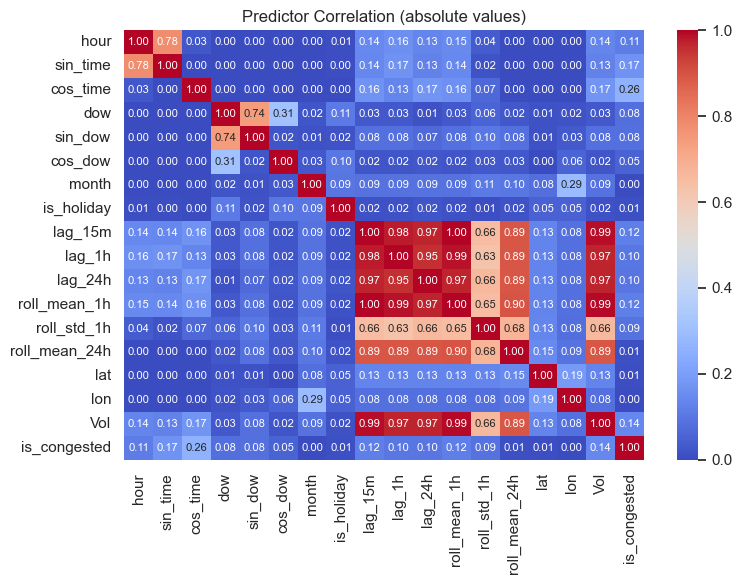

In [139]:
corr = df[num_cols].corr().abs()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}  # smaller font for annotations
)
plt.title("Predictor Correlation (absolute values)")
plt.tight_layout()
plt.show()


### 5.2 Drop features with high multicollinearity

#### 5.2.1 Identify pairs with strong relationship

In [144]:
# Identify pairs with |ρ| > 0.90
high_corr_pairs = [
    (c1, c2) for i, c1 in enumerate(predictor_cols)
             for c2 in predictor_cols[i+1:]
             if corr.loc[c1, c2] > 0.90
]
high_corr_pairs

[('lag_15m', 'lag_1h'),
 ('lag_15m', 'lag_24h'),
 ('lag_15m', 'roll_mean_1h'),
 ('lag_1h', 'lag_24h'),
 ('lag_1h', 'roll_mean_1h'),
 ('lag_24h', 'roll_mean_1h')]

#### 5.2.2 Drop features

In [147]:
drop_corr = set()
for c1, c2 in high_corr_pairs:
    # heuristic: keep the feature with lower overall correlation to others
    mean1 = corr[c1].mean()
    mean2 = corr[c2].mean()
    drop_corr.add(c1 if mean1 > mean2 else c2)
drop_corr

{'lag_15m', 'lag_1h', 'roll_mean_1h'}

In [149]:
df = df.drop(columns=list(drop_corr))
print(f"Dropping due to high correlation > 0.90: {sorted(drop_corr)}")
predictor_cols = [c for c in predictor_cols if c not in drop_corr]

Dropping due to high correlation > 0.90: ['lag_15m', 'lag_1h', 'roll_mean_1h']


### 5.3 Remaining features

In [152]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[predictor_cols].astype(float).copy()
X["const"] = 1.0              # add intercept

vif = pd.Series(
    [variance_inflation_factor(X.values, i) for i in range(X.shape[1]-1)],
    index=predictor_cols,
    name="VIF"
).sort_values(ascending=False)

print("VIF values:")
display(vif)

high_vif = vif[vif > 10].index.tolist()
if high_vif:
    print(f"Dropping features with VIF > 10: {high_vif}")
    df = df.drop(columns=high_vif)
    predictor_cols = [c for c in predictor_cols if c not in high_vif]

VIF values:


lag_24h          6.541171
roll_mean_24h    6.506851
dow              2.980471
sin_dow          2.691885
hour             2.603839
sin_time         2.587647
roll_std_1h      1.942467
cos_dow          1.314153
cos_time         1.187833
lon              1.162955
month            1.125689
lat              1.075592
is_holiday       1.035689
Name: VIF, dtype: float64

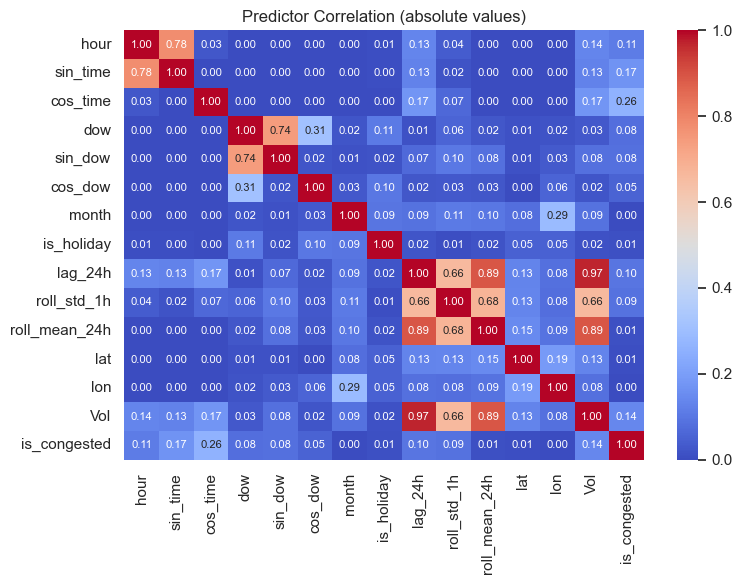

In [153]:
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr().abs()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    cmap="coolwarm",
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".2f",
    annot_kws={"size": 8}
)
plt.title("Predictor Correlation (absolute values)")
plt.tight_layout()
plt.show()

In [154]:
df

SegmentID              street  hour  sin_time  cos_time  \
timestamp                                                                     
2023-01-07 00:00:00    151516     FLATBUSH AVENUE     0  0.000000  1.000000   
2023-01-07 00:15:00    151516     FLATBUSH AVENUE     0  0.065403  0.997859   
2023-01-07 00:30:00    151516     FLATBUSH AVENUE     0  0.130526  0.991445   
2023-01-07 00:45:00    151516     FLATBUSH AVENUE     0  0.195090  0.980785   
2023-01-07 01:00:00    151516     FLATBUSH AVENUE     1  0.258819  0.965926   
...                       ...                 ...   ...       ...       ...   
2024-06-10 23:30:00     75814  NORTHERN BOULEVARD    23 -0.130526  0.991445   
2024-06-10 23:45:00     75814  NORTHERN BOULEVARD    23 -0.065403  0.997859   
2024-06-10 23:45:00     28962     FLATBUSH AVENUE    23 -0.065403  0.997859   
2024-06-10 23:45:00     75814  NORTHERN BOULEVARD    23 -0.065403  0.997859   
2024-06-10 23:45:00     28962     FLATBUSH AVENUE    23 -0.065403  0.997859   

                     dow   sin_dow   cos_dow  month  is_weekend  is_holiday  \
timestamp                                                                     
2023-01-07 00:00:00    5 -0.974928 -0.222521      1        True           0   
2023-01-07 00:15:00    5 -0.974928 -0.222521      1        True           0   
2023-01-07 00:30:00    5 -0.974928 -0.222521      1        True           0   
2023-01-07 00:45:00    5 -0.974928 -0.222521      1        True           0   
2023-01-07 01:00:00    5 -0.974928 -0.222521      1        True           0   
...                  ...       ...       ...    ...         ...         ...   
2024-06-10 23:30:00    0  0.000000  1.000000      6       False           0   
2024-06-10 23:45:00    0  0.000000  1.000000      6       False           0   
2024-06-10 23:45:00    0  0.000000  1.000000      6       False           0   
2024-06-10 23:45:00    0  0.000000  1.000000      6       False           0   
2024-06-10 23:45:00    0  0.000000  1.000000      6       False           0   

                     lag_24h  roll_std_1h  roll_mean_24h      Boro Direction  \
timestamp                                                                      
2023-01-07 00:00:00     81.0    13.073510     159.010417  Brooklyn        NB   
2023-01-07 00:15:00     67.0    14.430870     159.218750  Brooklyn        NB   
2023-01-07 00:30:00     48.0    21.432063     159.447917  Brooklyn        NB   
2023-01-07 00:45:00     41.0    13.500000     159.906250  Brooklyn        NB   
2023-01-07 01:00:00     42.0    12.819256     160.093750  Brooklyn        NB   
...                      ...          ...            ...       ...       ...   
2024-06-10 23:30:00     60.0     9.979145     116.187500    Queens        WB   
2024-06-10 23:45:00    122.0    12.935739     126.072917    Queens        EB   
2024-06-10 23:45:00    221.0    17.795130     172.375000  Brooklyn        SB   
2024-06-10 23:45:00     73.0     3.162278     115.916667    Queens        WB   
2024-06-10 23:45:00    124.0    15.588457     184.333333  Brooklyn        NB   

                           lat        lon    Vol  is_congested  
timestamp                                                       
2023-01-07 00:00:00  40.612781 -73.925797  103.0             0  
2023-01-07 00:15:00  40.612781 -73.925797   87.0             0  
2023-01-07 00:30:00  40.612781 -73.925797   70.0             0  
2023-01-07 00:45:00  40.612781 -73.925797   85.0             0  
2023-01-07 01:00:00  40.612781 -73.925797   60.0             0  
...                        ...        ...    ...           ...  
2024-06-10 23:30:00  40.754331 -73.897047   50.0             0  
2024-06-10 23:45:00  40.754331 -73.897047  103.0             0  
2024-06-10 23:45:00  40.683616 -73.977138  210.0             0  
2024-06-10 23:45:00  40.754331 -73.897047   47.0             0  
2024-06-10 23:45:00  40.683616 -73.977138  121.0             0  

[90152 rows x 20 columns]

## 6. Modelling

### 6.1 Define Features and Preprocesors

In [160]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

df_model = df.copy()

# Feature lists
num = [
    "hour", "sin_time", "cos_time",
    "dow", "sin_dow", "cos_dow",
    "month", "is_weekend", "is_holiday",
    "lag_24h", "roll_std_1h", "roll_mean_24h",
    "lat", "lon"
]
cat = ["Boro", "Direction"]
Xcols = num + cat
y_reg, y_cls = "Vol", "is_congested"

# Preprocessing: One-hot encode categorical, passthrough rest
pre = ColumnTransformer(
    [("cat", OneHotEncoder(handle_unknown="ignore"), cat)],
    remainder="passthrough"
)

### 6.2 Time-aware split: last 60 days for validation

In [162]:
cut = df_model.index.max() - pd.Timedelta(days=60)
X_train = df_model.loc[df_model.index < cut, Xcols]
X_val   = df_model.loc[df_model.index >= cut, Xcols]
y_tr_r  = df_model.loc[df_model.index < cut, y_reg]
y_val_r = df_model.loc[df_model.index >= cut, y_reg]
y_tr_c  = df_model.loc[df_model.index < cut, y_cls]
y_val_c = df_model.loc[df_model.index >= cut, y_cls]

print(f"Train rows: {len(X_train):,}  |  Valid rows: {len(X_val):,}")

Train rows: 80,550  |  Valid rows: 9,602


### 6.3  Baseline (use lag_24h) as predictor

In [164]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

baseline = df_model.loc[df_model.index >= cut, "lag_24h"]
mae_b  = mean_absolute_error(y_val_r, baseline)
rmse_b = mean_squared_error(y_val_r, baseline) ** 0.5
print(f"\nBaseline      MAE={mae_b:5.1f}  RMSE={rmse_b:5.1f}")

# regression metrics
def reg_report(name, true, pred, rmse_base):
    mae  = mean_absolute_error(true, pred)
    rmse = mean_squared_error(true, pred) ** 0.5
    r2   = r2_score(true, pred)
    lift = 100 * (rmse_base - rmse) / rmse_base
    print(f"{name:<6}  MAE={mae:5.1f}  RMSE={rmse:5.1f}  R²={r2:5.3f}  "
          f"(lift {lift:+4.1f}%)")


Baseline      MAE= 14.1  RMSE= 22.6


### 6.4 Train regressors (Volume measure)

In [166]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb

# Define a dictionary of models with varied techniques
models = {
    "Linear Regression": LinearRegression(),

    "Lasso Regression": Lasso(alpha=0.1),  # Regularized linear model

    "Random Forest": RandomForestRegressor(
        n_estimators=200, n_jobs=-1, random_state=42
    ),

    #"Support Vector Regressor": SVR(
    #    kernel='rbf', C=1.0, epsilon=0.2
    #),

    "XGBoost": xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
}

In [167]:
from sklearn.pipeline import make_pipeline

for name, mdl in models.items():
    pipe = make_pipeline(pre, mdl)
    pipe.fit(X_train, y_tr_r)
    pred = pipe.predict(X_val)
    reg_report(name, y_val_r, pred, rmse_b)

Linear Regression  MAE= 13.9  RMSE= 21.0  R²=0.889  (lift +7.1%)
Lasso Regression  MAE= 13.8  RMSE= 21.0  R²=0.889  (lift +7.0%)
Random Forest  MAE= 11.9  RMSE= 18.2  R²=0.917  (lift +19.6%)
XGBoost  MAE= 11.5  RMSE= 17.5  R²=0.923  (lift +22.7%)


### 6.5 Train Classifier (Congestion Label)

In [169]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb

classifiers = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear',
        random_state=42
    ),
    "Ridge Classifier": RidgeClassifier(
        alpha=1.0,
        class_weight='balanced',
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    # "SVM (RBF Kernel)": SVC(
    #     probability=True,
    #     C=1.0,
    #     gamma='scale',
    #     random_state=42
    # ),
    "XGBoost Classifier": xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        random_state=42
    )
}


In [173]:
from sklearn.metrics import f1_score, precision_score, recall_score

for name, model in classifiers.items():
    pipe_cls = make_pipeline(pre, model)
    pipe_cls.fit(X_train, y_tr_c)
    pred_c = pipe_cls.predict(X_val)

    f1   = f1_score(y_val_c, pred_c)
    prec = precision_score(y_val_c, pred_c)
    rec  = recall_score(y_val_c, pred_c)

    print(f"{name:<22} F1={f1:.3f}  Precision={prec:.3f}  Recall={rec:.3f}")


Logistic Regression    F1=0.475  Precision=0.337  Recall=0.805
Ridge Classifier       F1=0.433  Precision=0.298  Recall=0.793
Random Forest          F1=0.346  Precision=0.624  Recall=0.239
Gradient Boosting      F1=0.299  Precision=0.677  Recall=0.192
XGBoost Classifier     F1=0.257  Precision=0.677  Recall=0.158


## 7. Hyperparameter Tuning (RandomizedSearch)

In [175]:
REG_COL = "Vol"
X = df[Xcols]
y_reg = df[REG_COL]

In [176]:
# Time-Series Split

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=30 * 96, gap=96)

### 7.1 Regressor

#### 7.1.1 RandomForest Regressor

In [180]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
import joblib

rf_grid = {
    "randomforestregressor__n_estimators": [100, 200, 300],
    "randomforestregressor__max_depth": [10, 20, None],
    "randomforestregressor__min_samples_split": [2, 5, 10]
}

pipe_rf = make_pipeline(
    pre,
    RandomForestRegressor(
        n_jobs=-1,
        random_state=42
    )
)

rf_search = RandomizedSearchCV(
    pipe_rf,
    param_distributions=rf_grid,
    n_iter=10,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Tuning RandomForestRegressor")
rf_search.fit(X, y_reg)
print(f"Best RF CV RMSE = {-rf_search.best_score_:.2f}")
joblib.dump(rf_search.best_estimator_, "rf_regressor_randomsearch.pkl")

Tuning RandomForestRegressor
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF CV RMSE = 16.49


['rf_regressor_randomsearch.pkl']

In [181]:
#Parameters trained
model = joblib.load("rf_regressor_randomsearch.pkl")

rf_model = model.named_steps["randomforestregressor"]
print(rf_model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 20, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


#### 7.1.2 XGBoost Regressor Tuning

In [183]:
from sklearn.model_selection import RandomizedSearchCV
import joblib

xgb_grid = {
    "xgbregressor__n_estimators": [200, 400, 600],
    "xgbregressor__max_depth": [4, 6, 8],
    "xgbregressor__learning_rate": [0.05, 0.1, 0.2],
}

pipe_xgb = make_pipeline(
    pre,
    xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_jobs=-1,
        random_state=42
    )
)

xgb_search = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=xgb_grid,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Tuning XGBRegressor")
xgb_search.fit(X, y_reg)
print(f"Best CV RMSE = {-xgb_search.best_score_:.2f}")
joblib.dump(xgb_search.best_estimator_, "xgb_regressor_randomsearch.pkl")

Tuning XGBRegressor
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best CV RMSE = 15.80


['xgb_regressor_randomsearch.pkl']

In [184]:
#Parameters trained
model = joblib.load("xgb_regressor_randomsearch.pkl")

rf_model = model.named_steps["xgbregressor"]
print(rf_model.get_params())

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'rmse', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


### 7.2 Classifier

In [186]:
CLS_COL = "is_congested"
X, y_cls = df[Xcols], df[CLS_COL]
pos_weight = (y_cls == 0).sum() / max((y_cls == 1).sum(), 1)

In [187]:
from sklearn.metrics import f1_score, make_scorer

# F1 Score
f1_safe = make_scorer(f1_score, zero_division=1)

#### 7.2.1 Ridge Classifier Tuning

In [189]:
from sklearn.linear_model import RidgeClassifier

ridge_grid = {
    "ridgeclassifier__alpha": np.logspace(-3, 2, 5)  # regularization strength
}

pipe_ridge = make_pipeline(
    pre,
    RidgeClassifier(
        class_weight="balanced",
        random_state=42
    )
)

ridge_search = RandomizedSearchCV(
    pipe_ridge,
    param_distributions=ridge_grid,
    n_iter=5,
    scoring=f1_safe,
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Tuning RidgeClassifier")
ridge_search.fit(X, y_cls)
print(f"Best Ridge F1 = {ridge_search.best_score_:.3f}")
joblib.dump(ridge_search.best_estimator_, "ridge_classifier_randomsearch.pkl")

Tuning RidgeClassifier
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Ridge F1 = 0.428


['ridge_classifier_randomsearch.pkl']

In [190]:
#Parameters trained
model = joblib.load("ridge_classifier_randomsearch.pkl")

rf_model = model.named_steps["ridgeclassifier"]
print(rf_model.get_params())

{'alpha': 0.001, 'class_weight': 'balanced', 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 42, 'solver': 'auto', 'tol': 0.0001}


#### 7.2.2 XGBoost Classifier Tuning

In [192]:
xgb_grid = {
    "xgbclassifier__n_estimators": [200, 400, 600],
    "xgbclassifier__max_depth": [4, 6, 8],
    "xgbclassifier__learning_rate": [0.05, 0.1, 0.2],
}

pipe_xgb = make_pipeline(
    pre,
    xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
        scale_pos_weight=pos_weight
    )
)

xgb_search = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=xgb_grid,
    n_iter=20,
    scoring=f1_safe,
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Tuning XGBClassifier")
xgb_search.fit(X, y_cls)
print(f"Best XGB F1 = {xgb_search.best_score_:.3f}")
joblib.dump(xgb_search.best_estimator_, "XGBoost_Classifier_Randomsearch.pkl")

Tuning XGBClassifier
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGB F1 = 0.514


['XGBoost_Classifier_Randomsearch.pkl']

In [193]:
#Parameters trained
model = joblib.load("XGBoost_Classifier_Randomsearch.pkl")

rf_model = model.named_steps["xgbclassifier"]
print(rf_model.get_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 600, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 6.0768506162179134, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


## 8. GridSearch (Around best Random Search Parameters)

### 8.1 GridSearch for best identified Model for Regressor

In [196]:
from sklearn.model_selection import GridSearchCV

# Grid definition
xgbreg_grid = {
    "xgbregressor__n_estimators": [200, 300, 400],
    "xgbregressor__max_depth": [6, 8],
    "xgbregressor__learning_rate": [0.05, 0.1, 0.15],
}

# Pipeline
pipe_reg = make_pipeline(
    pre,
    xgb.XGBRegressor(
        objective="reg:squarederror",
        eval_metric="rmse",
        n_jobs=-1,
        random_state=42
    )
)

# GridSearchCV
search_reg = GridSearchCV(
    pipe_reg,
    param_grid=xgbreg_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print("Tuning XGBRegressor via GridSearch")
search_reg.fit(X, y_reg)
print(f"Best XGBReg CV RMSE = {-search_reg.best_score_:.2f}")
joblib.dump(search_reg.best_estimator_, "NYC_Predict_Traffic_Regressor.pkl")

Tuning XGBRegressor via GridSearch
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best XGBReg CV RMSE = 15.80


['NYC_Predict_Traffic_Regressor.pkl']

### 8.2 GridSearch for best identified Model for Classifier

In [198]:
# 1. Grid around known good parameters
xgbcls_grid = {
    "xgbclassifier__n_estimators": [400, 500, 600],
    "xgbclassifier__max_depth": [3, 4, 5],
    "xgbclassifier__learning_rate": [0.08, 0.1, 0.12],
    "xgbclassifier__subsample": [0.8, 1.0],
    "xgbclassifier__colsample_bytree": [0.8, 1.0],
    "xgbclassifier__gamma": [0, 1, 3]
}

# 2. Pipeline: Preprocessor + XGBClassifier
pipe_cls = make_pipeline(
    pre,
    xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_jobs=-1,
        random_state=42,
        scale_pos_weight=pos_weight
    )
)

# 3. GridSearchCV setup
f1_safe = make_scorer(f1_score, zero_division=1)

search_cls = GridSearchCV(
    pipe_cls,
    param_grid=xgbcls_grid,
    scoring=f1_safe,
    cv=tscv,           # TimeSeriesSplit defined earlier
    n_jobs=-1,
    verbose=1,
    refit=True
)

# 4. Run search and save best model
print("Tuning XGBClassifier via GridSearch")
search_cls.fit(X, y_cls)
print(f"Best CV F1 = {search_cls.best_score_:.3f}")
print("Best Params:", search_cls.best_params_)
joblib.dump(search_cls.best_estimator_, "NYC_Predict_Congestion_Classifier.pkl")

Tuning XGBClassifier via GridSearch
Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best CV F1 = 0.528
Best Params: {'xgbclassifier__colsample_bytree': 1.0, 'xgbclassifier__gamma': 3, 'xgbclassifier__learning_rate': 0.12, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 600, 'xgbclassifier__subsample': 0.8}


['NYC_Predict_Congestion_Classifier.pkl']

## 9. Model Evaluation

### 9.1 Load Trained Models

In [201]:
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    classification_report, roc_curve, auc, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay
)

cutoff = df.index.max() - pd.Timedelta(days=60)
X_train = df.loc[df.index < cutoff, Xcols]
X_val   = df.loc[df.index >= cutoff, Xcols]

y_val_reg = df.loc[df.index >= cutoff, "Vol"]
y_val_cls = df.loc[df.index >= cutoff, "is_congested"]

print(f"Validation set size: {len(X_val):,} rows")

reg_pipe = joblib.load("NYC_Predict_Traffic_Regressor.pkl")
cls_pipe = joblib.load("NYC_Predict_Congestion_Classifier.pkl")

Validation set size: 9,602 rows


### 9.2 Regression Metrics

In [203]:
pred_reg = reg_pipe.predict(X_val)
residuals = y_val_reg - pred_reg

mae = mean_absolute_error(y_val_reg, pred_reg)
rmse = mean_squared_error(y_val_reg, pred_reg) ** 0.5
r2 = r2_score(y_val_reg, pred_reg)

print("\n📉 Regression metrics:")
print(f"    MAE  = {mae:.2f}")
print(f"    RMSE = {rmse:.2f}")
print(f"    R²   = {r2:.3f}")


📉 Regression metrics:
    MAE  = 8.19
    RMSE = 11.49
    R²   = 0.967


### 9.3 Residual Plot

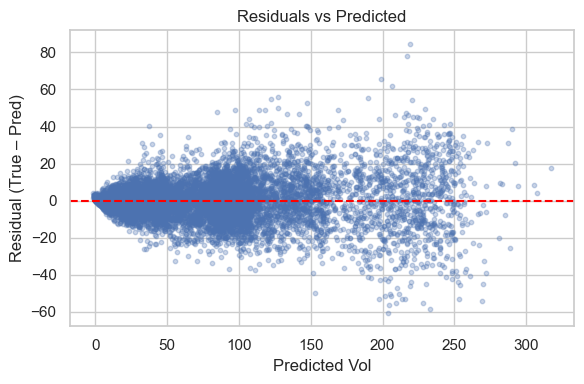

In [205]:
plt.figure(figsize=(6, 4))
plt.scatter(pred_reg, residuals, alpha=0.3, s=10)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Vol")
plt.ylabel("Residual (True – Pred)")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.show()

### 9.4 Residual Distribution

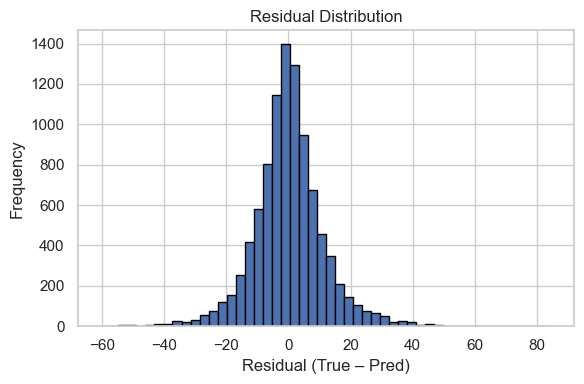

In [207]:
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, edgecolor="black")
plt.xlabel("Residual (True – Pred)")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.tight_layout()
plt.show()

### 9.5 Hour of Day: Error Analysis

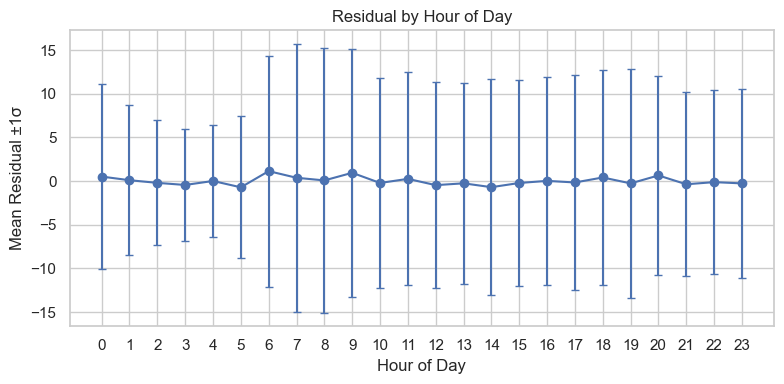

In [209]:
hour_val = X_val.index.hour
hourly_err = pd.DataFrame({
    "residual": residuals,
    "hour": hour_val
}).groupby("hour")["residual"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(8, 4))
plt.errorbar(
    hourly_err["hour"],
    hourly_err["mean"],
    yerr=hourly_err["std"],
    fmt="o-", capsize=3
)
plt.xlabel("Hour of Day")
plt.ylabel("Mean Residual ±1σ")
plt.title("Residual by Hour of Day")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

### 9.6 Classification Metrics


📊 Classification Report:
              precision    recall  f1-score   support

           0      0.989     0.840     0.909      8174
           1      0.509     0.947     0.662      1428

    accuracy                          0.856      9602
   macro avg      0.749     0.894     0.785      9602
weighted avg      0.918     0.856     0.872      9602



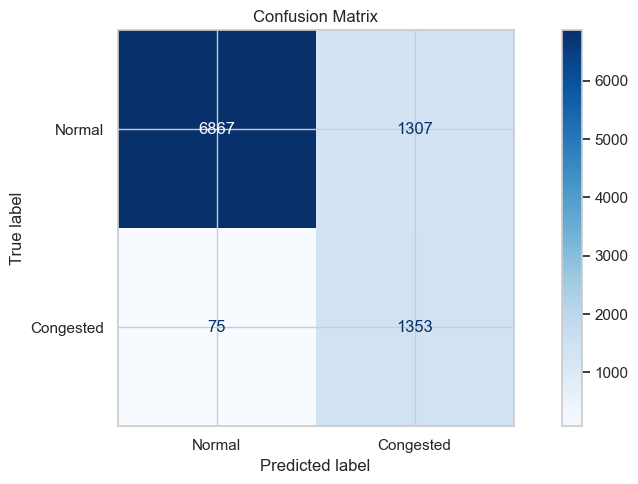

In [211]:
pred_proba = cls_pipe.predict_proba(X_val)[:, 1]
pred_cls = (pred_proba >= 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_val_cls, pred_cls, digits=3))

cm = confusion_matrix(y_val_cls, pred_cls)
ConfusionMatrixDisplay(cm, display_labels=["Normal", "Congested"]).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


### 9.7 ROC Curve

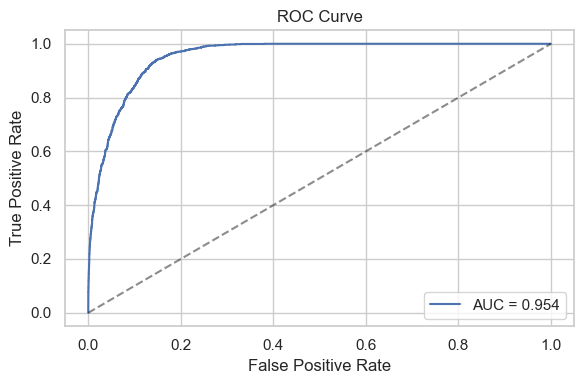

In [213]:
fpr, tpr, _ = roc_curve(y_val_cls, pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", alpha=0.5)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 9.8 POC Curve

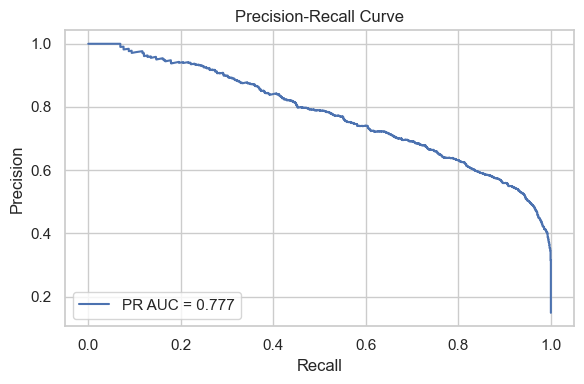

In [215]:
precision, recall, _ = precision_recall_curve(y_val_cls, pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

### 9.9 Feature Importance

In [217]:
import shap

xgb_model = reg_pipe.named_steps["xgbregressor"]

# Preprocess X_val (excluding the XGB model itself)
preprocessor = reg_pipe.named_steps["columntransformer"]
X_val_transformed = preprocessor.transform(X_val)

explainer = shap.TreeExplainer(xgb_model)
idx_sample = np.random.choice(
    X_val_transformed.shape[0],
    size=min(5000, X_val_transformed.shape[0]),
    replace=False
)
X_sample = X_val_transformed[idx_sample]
shap_values = explainer.shap_values(X_sample)

# Retrieve the transformed feature names
transformed_names = preprocessor.get_feature_names_out()

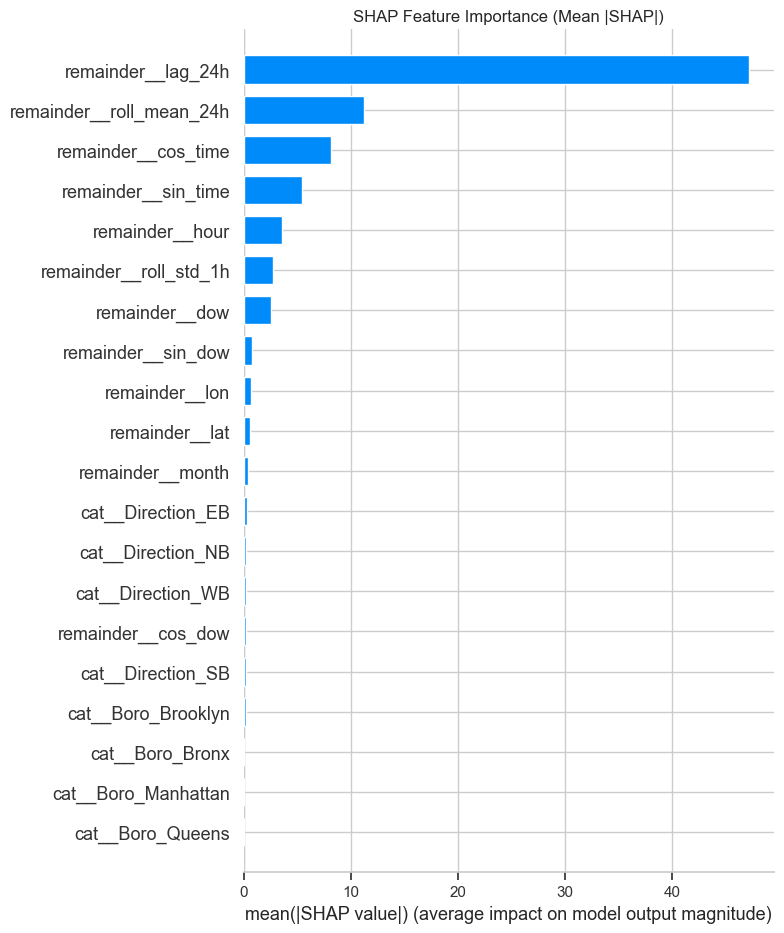

In [218]:
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=transformed_names,
    plot_type="bar",
    show=False
)
plt.title("SHAP Feature Importance (Mean |SHAP|)")
plt.tight_layout()
plt.show()

## 10. Demo Model

### 10.1 Load trained pipelines

In [221]:
reg_model = joblib.load("NYC_Predict_Traffic_Regressor.pkl") 
cls_model = joblib.load("NYC_Predict_Congestion_Classifier.pkl")

### 10.2 Take demo rows

In [223]:
demo_df = df.tail(2000).copy()

# Use the same columns as in training
feature_cols = Xcols  # from Section 8

missing_feats = [c for c in feature_cols if c not in demo_df.columns]
if missing_feats:
    raise RuntimeError(f"Missing columns in demo_df: {missing_feats}")

X_demo = demo_df[feature_cols]

### 10.3 Run Predictions

In [225]:
demo_df["predicted_vol"] = reg_model.predict(X_demo)
demo_df["cong_proba"]     = cls_model.predict_proba(X_demo)[:, 1]
demo_df["predicted_cong"] = (demo_df["cong_proba"] >= 0.5).astype("int8")

output_cols = [
    "SegmentID", "Boro", "Direction",
    "Vol", "predicted_vol", "cong_proba", "predicted_cong"
]

display(demo_df.reset_index()[output_cols])

SegmentID      Boro Direction    Vol  predicted_vol  cong_proba  \
0        28962  Brooklyn        SB  192.0     228.052750    0.638972   
1        75814    Queens        WB  135.0     140.637741    0.190564   
2        28962  Brooklyn        NB  225.0     225.460861    0.597908   
3        75814    Queens        EB  182.0     194.114639    0.941045   
4        75814    Queens        WB  124.0     126.524178    0.177117   
...        ...       ...       ...    ...            ...         ...   
1995     75814    Queens        WB   50.0      58.447266    0.000144   
1996     75814    Queens        EB  103.0      97.658859    0.001411   
1997     28962  Brooklyn        SB  210.0     199.795898    0.010899   
1998     75814    Queens        WB   47.0      60.853600    0.000043   
1999     28962  Brooklyn        NB  121.0     128.069122    0.003112   

      predicted_cong  
0                  1  
1                  0  
2                  1  
3                  1  
4                  0  
...              ...  
1995               0  
1996               0  
1997               0  
1998               0  
1999               0  

[2000 rows x 7 columns]

### 10.4 Highest Mean absolute error Segments

In [227]:
val_segments = df_model.loc[df_model.index >= cutoff, ["SegmentID"]].copy()
val_segments["residual_abs"] = np.abs(residuals.values)

seg_err = (
    val_segments
    .groupby("SegmentID")["residual_abs"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"residual_abs": "mean_abs_error"})
)

display(seg_err.head())

SegmentID  mean_abs_error
0     28962       15.726829
1     75814       10.334677
2     21371        8.122902
3     41867        7.685559
4     42089        7.127138

### 10.5 Lowest Mean absolute error Segments

In [229]:
display(seg_err.tail())

SegmentID  mean_abs_error
5    167253        7.086297
6     22388        6.951060
7   9006518        6.187485
8     42646        4.240674
9    148375        3.754554

### 10.6 Overall Actual vs. Predicted Scatter

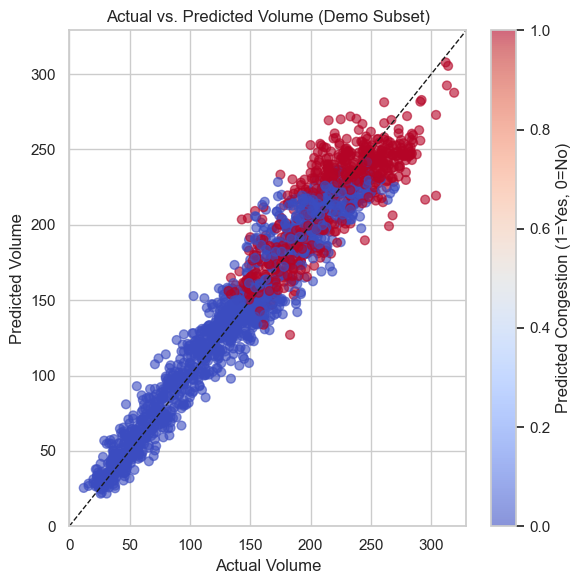

In [231]:
# Reset index so we have a timestamp column for plotting
demo_plot = demo_df.reset_index().rename(columns={"index": "timestamp"})

# ---------------------------------------------------------
# 14.2  Overall Actual vs. Predicted Scatter
# ---------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.scatter(
    demo_plot["Vol"],
    demo_plot["predicted_vol"],
    alpha=0.6,
    s=40,
    c=demo_plot["predicted_cong"],      # color by predicted congestion flag
    cmap="coolwarm"
)
max_val = max(demo_plot["Vol"].max(), demo_plot["predicted_vol"].max()) + 10
plt.plot([0, max_val], [0, max_val], "k--", linewidth=1)
plt.xlabel("Actual Volume")
plt.ylabel("Predicted Volume")
plt.title("Actual vs. Predicted Volume (Demo Subset)")
cbar = plt.colorbar(label="Predicted Congestion (1=Yes, 0=No)")
plt.xlim(0, max_val)
plt.ylim(0, max_val)
plt.tight_layout()
plt.show()

### 10.7 Error Distribution (Residuals)

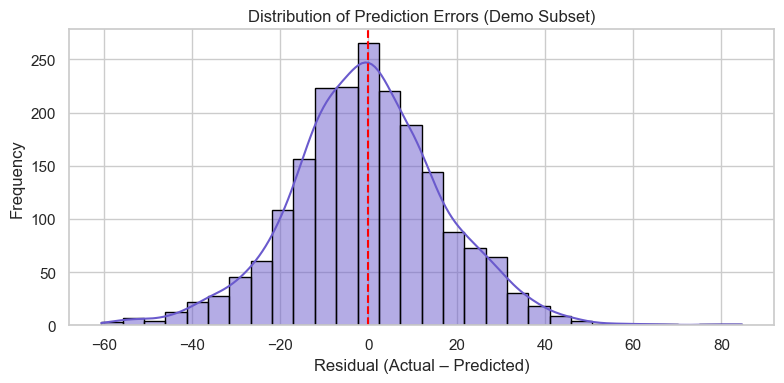

In [233]:
demo_plot["residual"] = demo_plot["Vol"] - demo_plot["predicted_vol"]

plt.figure(figsize=(8, 4))
sns.histplot(
    demo_plot["residual"],
    bins=30,
    kde=True,
    color="slateblue",
    edgecolor="black"
)
plt.axvline(0, color="red", linestyle="--")
plt.xlabel("Residual (Actual – Predicted)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors (Demo Subset)")
plt.tight_layout()
plt.show()

### 10.8 Time-Series

#### 10.8.1 Time-Series Plot

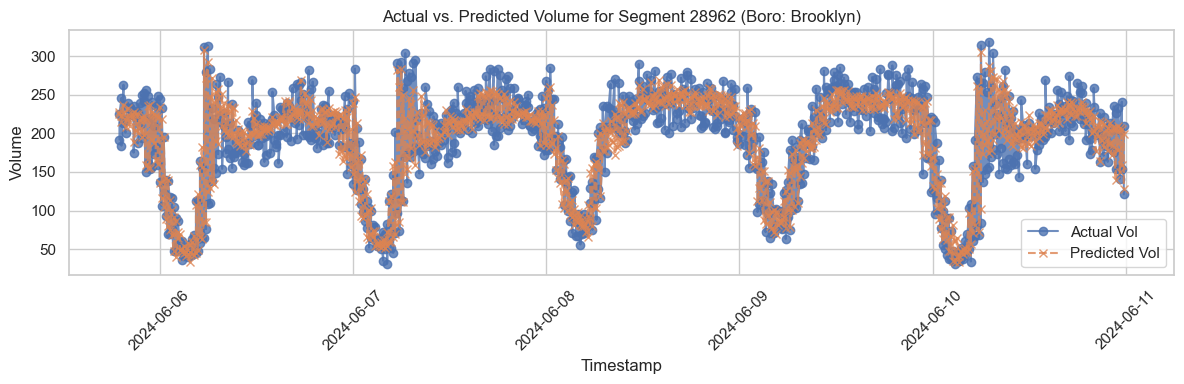

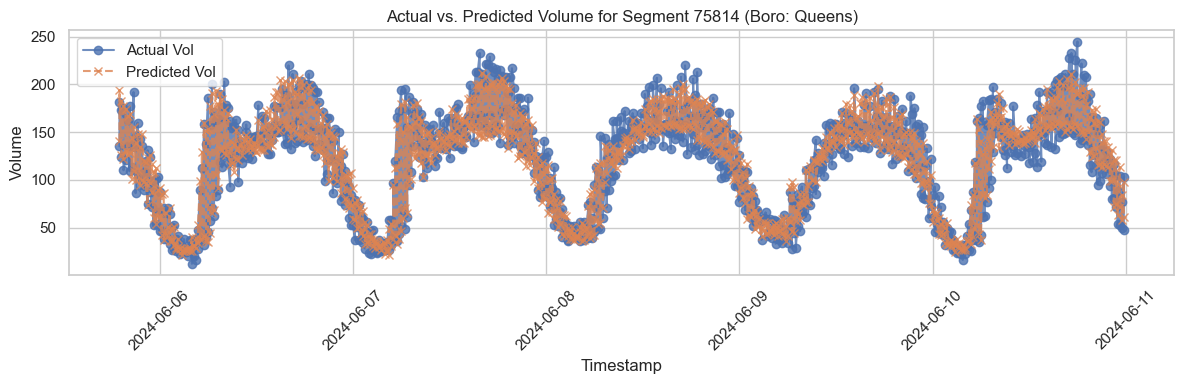

In [236]:
example_segs = demo_plot["SegmentID"].unique()[:2]  # first two unique segments

for seg in example_segs:
    seg_df = demo_plot[demo_plot["SegmentID"] == seg]
    plt.figure(figsize=(12, 4))
    plt.plot(
        seg_df["timestamp"],
        seg_df["Vol"],
        marker="o",
        linestyle="-",
        label="Actual Vol",
        alpha=0.8
    )
    plt.plot(
        seg_df["timestamp"],
        seg_df["predicted_vol"],
        marker="x",
        linestyle="--",
        label="Predicted Vol",
        alpha=0.8
    )
    plt.xlabel("Timestamp")
    plt.ylabel("Volume")
    plt.title(f"Actual vs. Predicted Volume for Segment {seg} (Boro: {seg_df['Boro'].iloc[0]})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### 10.8.2 FacetGrid

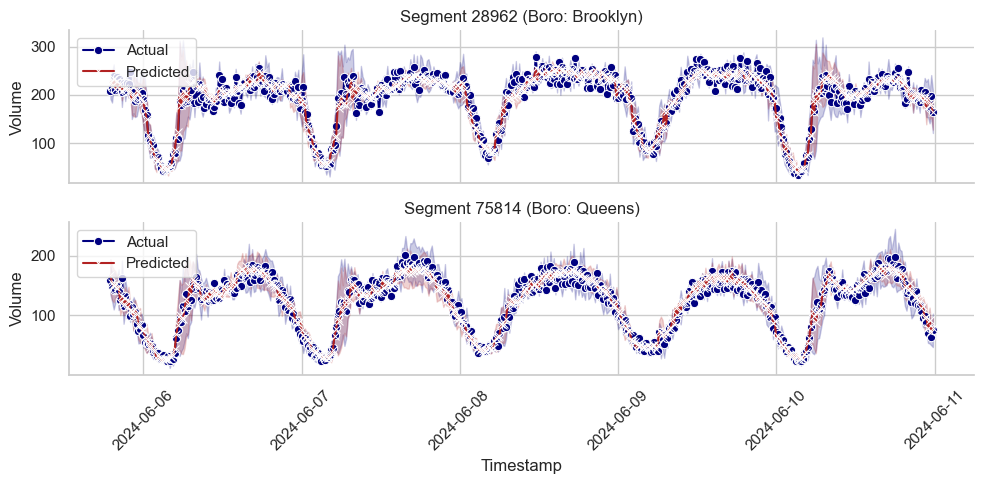

In [238]:
unique_segs = demo_plot["SegmentID"].unique()[:4]
facet_df = demo_plot[demo_plot["SegmentID"].isin(unique_segs)].copy()

g = sns.FacetGrid(
    facet_df, 
    row="SegmentID", 
    height=2.5, 
    aspect=4, 
    sharey=False, 
    sharex=True
)
g.map_dataframe(
    sns.lineplot, 
    x="timestamp", 
    y="Vol", 
    label="Actual", 
    marker="o", 
    color="navy"
)
g.map_dataframe(
    sns.lineplot, 
    x="timestamp", 
    y="predicted_vol", 
    label="Predicted", 
    marker="x", 
    color="firebrick"
)
for ax, seg in zip(g.axes.flatten(), unique_segs):
    boro = facet_df[facet_df["SegmentID"] == seg]["Boro"].iloc[0]
    ax.set_title(f"Segment {seg} (Boro: {boro})")
    ax.tick_params(axis="x", rotation=45)
    ax.legend(loc="upper left")
g.set_axis_labels("Timestamp", "Volume")
plt.tight_layout()
plt.show()

### 10.9 Residual vs. Time Colored by Segment

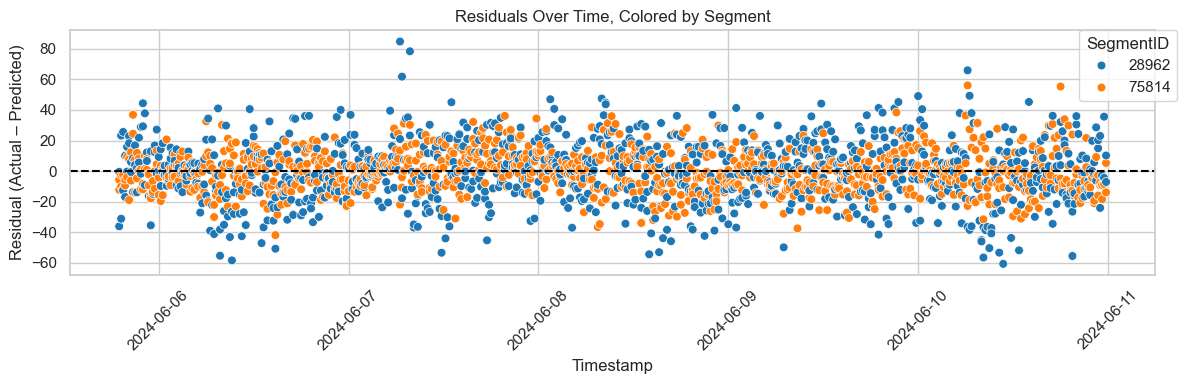

In [240]:
plt.figure(figsize=(12, 4))
sns.scatterplot(
    data=demo_plot,
    x="timestamp",
    y="residual",
    hue="SegmentID",
    palette="tab10",
    s=40
)
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Timestamp")
plt.ylabel("Residual (Actual – Predicted)")
plt.title("Residuals Over Time, Colored by Segment")
plt.xticks(rotation=45)
plt.legend(title="SegmentID", bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.tight_layout()
plt.show()

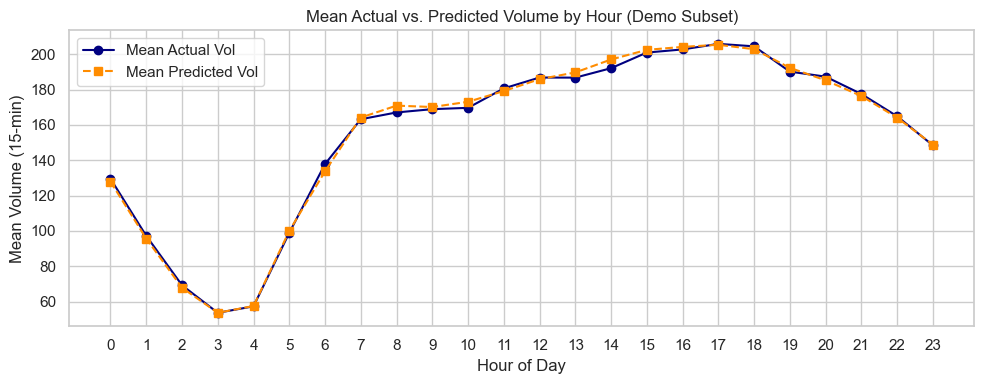

In [241]:
agg_profile = (
    demo_plot
    .assign(hour=demo_plot["timestamp"].dt.hour)
    .groupby("hour")
    .agg({"Vol": "mean", "predicted_vol": "mean"})
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.plot(
    agg_profile["hour"],
    agg_profile["Vol"],
    marker="o",
    label="Mean Actual Vol",
    color="navy"
)
plt.plot(
    agg_profile["hour"],
    agg_profile["predicted_vol"],
    marker="s",
    linestyle="--",
    label="Mean Predicted Vol",
    color="darkorange"
)
plt.xlabel("Hour of Day")
plt.ylabel("Mean Volume (15-min)")
plt.title("Mean Actual vs. Predicted Volume by Hour (Demo Subset)")
plt.legend()
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [242]:
# All columns
demo_df

SegmentID              street  hour  sin_time  cos_time  \
timestamp                                                                     
2024-06-05 19:00:00     28962     FLATBUSH AVENUE    19 -0.965926  0.258819   
2024-06-05 19:00:00     75814  NORTHERN BOULEVARD    19 -0.965926  0.258819   
2024-06-05 19:00:00     28962     FLATBUSH AVENUE    19 -0.965926  0.258819   
2024-06-05 19:00:00     75814  NORTHERN BOULEVARD    19 -0.965926  0.258819   
2024-06-05 19:15:00     75814  NORTHERN BOULEVARD    19 -0.946930  0.321439   
...                       ...                 ...   ...       ...       ...   
2024-06-10 23:30:00     75814  NORTHERN BOULEVARD    23 -0.130526  0.991445   
2024-06-10 23:45:00     75814  NORTHERN BOULEVARD    23 -0.065403  0.997859   
2024-06-10 23:45:00     28962     FLATBUSH AVENUE    23 -0.065403  0.997859   
2024-06-10 23:45:00     75814  NORTHERN BOULEVARD    23 -0.065403  0.997859   
2024-06-10 23:45:00     28962     FLATBUSH AVENUE    23 -0.065403  0.997859   

                     dow   sin_dow   cos_dow  month  is_weekend  is_holiday  \
timestamp                                                                     
2024-06-05 19:00:00    2  0.974928 -0.222521      6       False           0   
2024-06-05 19:00:00    2  0.974928 -0.222521      6       False           0   
2024-06-05 19:00:00    2  0.974928 -0.222521      6       False           0   
2024-06-05 19:00:00    2  0.974928 -0.222521      6       False           0   
2024-06-05 19:15:00    2  0.974928 -0.222521      6       False           0   
...                  ...       ...       ...    ...         ...         ...   
2024-06-10 23:30:00    0  0.000000  1.000000      6       False           0   
2024-06-10 23:45:00    0  0.000000  1.000000      6       False           0   
2024-06-10 23:45:00    0  0.000000  1.000000      6       False           0   
2024-06-10 23:45:00    0  0.000000  1.000000      6       False           0   
2024-06-10 23:45:00    0  0.000000  1.000000      6       False           0   

                     lag_24h  roll_std_1h  roll_mean_24h      Boro Direction  \
timestamp                                                                      
2024-06-05 19:00:00    243.0    14.795833     177.583333  Brooklyn        SB   
2024-06-05 19:00:00    143.0     2.380476     115.531250    Queens        WB   
2024-06-05 19:00:00    228.0    12.526638     188.802083  Brooklyn        NB   
2024-06-05 19:00:00    203.0    14.843629     121.781250    Queens        EB   
2024-06-05 19:15:00    110.0     7.325754     115.677083    Queens        WB   
...                      ...          ...            ...       ...       ...   
2024-06-10 23:30:00     60.0     9.979145     116.187500    Queens        WB   
2024-06-10 23:45:00    122.0    12.935739     126.072917    Queens        EB   
2024-06-10 23:45:00    221.0    17.795130     172.375000  Brooklyn        SB   
2024-06-10 23:45:00     73.0     3.162278     115.916667    Queens        WB   
2024-06-10 23:45:00    124.0    15.588457     184.333333  Brooklyn        NB   

                           lat        lon    Vol  is_congested  predicted_vol  \
timestamp                                                                       
2024-06-05 19:00:00  40.683616 -73.977138  192.0             0     228.052750   
2024-06-05 19:00:00  40.754331 -73.897047  135.0             0     140.637741   
2024-06-05 19:00:00  40.683616 -73.977138  225.0             0     225.460861   
2024-06-05 19:00:00  40.754331 -73.897047  182.0             1     194.114639   
2024-06-05 19:15:00  40.754331 -73.897047  124.0             0     126.524178   
...                        ...        ...    ...           ...            ...   
2024-06-10 23:30:00  40.754331 -73.897047   50.0             0      58.447266   
2024-06-10 23:45:00  40.754331 -73.897047  103.0             0      97.658859   
2024-06-10 23:45:00  40.683616 -73.977138  210.0             0     199.795898   
2024-06-10 23:45:00  40.754331 -

In [243]:
# Features used
X_demo

hour  sin_time  cos_time  dow   sin_dow   cos_dow  month  \
timestamp                                                                       
2024-06-05 19:00:00    19 -0.965926  0.258819    2  0.974928 -0.222521      6   
2024-06-05 19:00:00    19 -0.965926  0.258819    2  0.974928 -0.222521      6   
2024-06-05 19:00:00    19 -0.965926  0.258819    2  0.974928 -0.222521      6   
2024-06-05 19:00:00    19 -0.965926  0.258819    2  0.974928 -0.222521      6   
2024-06-05 19:15:00    19 -0.946930  0.321439    2  0.974928 -0.222521      6   
...                   ...       ...       ...  ...       ...       ...    ...   
2024-06-10 23:30:00    23 -0.130526  0.991445    0  0.000000  1.000000      6   
2024-06-10 23:45:00    23 -0.065403  0.997859    0  0.000000  1.000000      6   
2024-06-10 23:45:00    23 -0.065403  0.997859    0  0.000000  1.000000      6   
2024-06-10 23:45:00    23 -0.065403  0.997859    0  0.000000  1.000000      6   
2024-06-10 23:45:00    23 -0.065403  0.997859    0  0.000000  1.000000      6   

                     is_weekend  is_holiday  lag_24h  roll_std_1h  \
timestamp                                                           
2024-06-05 19:00:00       False           0    243.0    14.795833   
2024-06-05 19:00:00       False           0    143.0     2.380476   
2024-06-05 19:00:00       False           0    228.0    12.526638   
2024-06-05 19:00:00       False           0    203.0    14.843629   
2024-06-05 19:15:00       False           0    110.0     7.325754   
...                         ...         ...      ...          ...   
2024-06-10 23:30:00       False           0     60.0     9.979145   
2024-06-10 23:45:00       False           0    122.0    12.935739   
2024-06-10 23:45:00       False           0    221.0    17.795130   
2024-06-10 23:45:00       False           0     73.0     3.162278   
2024-06-10 23:45:00       False           0    124.0    15.588457   

                     roll_mean_24h        lat        lon      Boro Direction  
timestamp                                                                     
2024-06-05 19:00:00     177.583333  40.683616 -73.977138  Brooklyn        SB  
2024-06-05 19:00:00     115.531250  40.754331 -73.897047    Queens        WB  
2024-06-05 19:00:00     188.802083  40.683616 -73.977138  Brooklyn        NB  
2024-06-05 19:00:00     121.781250  40.754331 -73.897047    Queens        EB  
2024-06-05 19:15:00     115.677083  40.754331 -73.897047    Queens        WB  
...                            ...        ...        ...       ...       ...  
2024-06-10 23:30:00     116.187500  40.754331 -73.897047    Queens        WB  
2024-06-10 23:45:00     126.072917  40.754331 -73.897047    Queens        EB  
2024-06-10 23:45:00     172.375000  40.683616 -73.977138  Brooklyn        SB  
2024-06-10 23:45:00     115.916667  40.754331 -73.897047    Queens        WB  
2024-06-10 23:45:00     184.333333  40.683616 -73.977138  Brooklyn        NB  

[2000 rows x 16 columns]

## 11. Conclusion

### 11.1 Proactive Signal Timing

With our forecasts, traffic lights can be adjusted before a jam starts. Instead of using fixed schedules, signals adapt so drivers hit more greens and fewer reds. That means less waiting at lights and smoother trips through town.

### 11.2 Borough-Level Insights

The maps show how traffic patterns change across the five boroughs and on weekends. For instance, Manhattan’s major streets crowd in the evening, while some Brooklyn roads spike at lunchtime. Planners can use these visuals to send help or tweak signals right where it’s needed.

### 11.3 Economic & Environmental Benefits

By turning raw traffic data into clear next steps, NYC can cut down on stop-and-go driving. Less idling means lower fuel costs and fewer emissions. Plus, when people spend less time stuck in traffic, they’re happier and more productive.

## 12. Next Steps (Advanced Data Analysis)

While the current pipelines provide strong baseline accuracy, adopting classical time‐series methods, integrating exogenous factors, and establishing a robust retraining framework will close remaining gaps that will drive continual improvement in predictive power and operational readiness.


- 1. Enhance Time-Series Foundations (Assess Stationarity & Seasonality: Decompose each segment’s series into trend, seasonal, and residual components)
- 2. Incorporate Exogenous Drivers (Link historical weather like rain and temperature as well as major event schedules to ATR counts: these often trigger atypical spikes)
- 3. Collect roadway metadata (number of lanes, speed limits) to refine model accuracy
- 4. Comparsion with Classical Time-Series Models: Use Arima on aggregated daily totals
- 5. Develop a simple REST API that serves 15‐min forecasts and congestion flags to traffic‐management centers
- 6. Create interactive dashboards (e.g., hourly heatmaps, map overlays) to visualize live signals